# Understanding galaxy star formation rate estimates using radio luminosities

The star formation rate (SFR) of a galaxy is a fundamental property describing its current degree of activity and (together with its stellar mass) its current evolutionary state. There are, however, many different ways to estimate galaxy star formation rates, and all suffer from various limitations. Radio luminosity is potentially a unique tracer for this key property, presuming that any contribution from an active galactic nucleus (AGN) can be excluded, due to its direct link to the high-mass stellar population. In this project we will use data from EMU early science observations and the GAMA survey, in the G23 field. After excluding AGN systems through standard emission line diagnostics, we will explore a suite of common SFR estimators, and compare these against a selection of published radio SFR estimators, newly calculated for the EMU/GAMA data. We will also use the population synthesis tool, ProSpect, to provide independent SFR estimates (without relying on the radio data), as a step toward synthesising all available photometry in inferring SFRs. We will, finally, use ProSpect again to incorporate the radio measurements explicitly to derive refined SFRs, and use these directly to assess the reliabiility and robustness of any SFR estimates based on radio luminosity in isolation. A stretch goal for this project will be to link the SFRs and stellar masses for this sample to explore the “galaxy main sequence” of SFR as a function of stellar mass, and how it evolves over the redshift range spanned by the GAMA measurements.

## <span style='background :LightPink' > Load in Packages

In [912]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
import cosmopy
import math
import seaborn as sns
from statistics import mean

import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9
from scipy.optimize import curve_fit
from scipy.stats import norm 

In [2]:
import matplotlib.colors as colors
from matplotlib import path
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

### <span style='background :LightPink' > Install packages

In [3]:
pip install cosmopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## <span style='background :LightPink' > Load in Data

In [5]:
cd \Project_AHopkins\Data

G:\Project_AHopkins\Data


### <span style='background :LightPink' > EMU Data

In [6]:
EMU_G23=fits.open('G23-ASKAP-EMUES-master-cat.fits')

In [7]:
EMU_G23.info()

Filename: G23-ASKAP-EMUES-master-cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1986,)   uint8   
  1  Joined        1 BinTableHDU     69   39812R x 27C   [19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, D, K, D, D]   


In [8]:
EMU_data=Table(EMU_G23[1].data)
#EMU_data

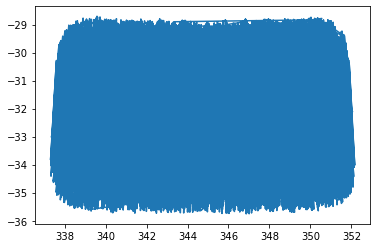

In [9]:
plt.plot(EMU_data['RA'], EMU_data['DEC'])

### <span style='background :LightPink' > GAMA

In [10]:
GFit=fits.open('GaussFitSimplev05.fits')
gkv=fits.open('gkvScienceCatv02.fits')
SMasses=fits.open('StellarMassesGKVv24.fits')

In [11]:
# GFit.info()
# gkv.info()
# SMasses.info()

In [12]:
GFit_data=Table(GFit[1].data)
#GFit_data

In [13]:
gkv_data=Table(gkv[1].data)
#gkv_data

In [14]:
SMasses_data=Table(SMasses[1].data)
#SMasses_data

In [15]:
SMasses_pd=SMasses_data.to_pandas()
gkv_pd=gkv_data.to_pandas()
GFit_pd=GFit_data.to_pandas()
EMU_pd=EMU_data.to_pandas()

#SMasses_pd

In [16]:
SMasses_pd.loc[:,"uberID"]

0         174001148708942
1         174001129809205
2         174001086008788
3         174001084207633
4         174001048108112
               ...       
370111    133000496408411
370112    176000226808518
370113    220000351709169
370114    178010820103143
370115    181010372002164
Name: uberID, Length: 370116, dtype: int64

In [17]:
GFit_pd=GFit_pd[GFit_pd.HA_FLUX >0]
#GFit_pd

In [18]:
GFit_pd=GFit_pd[GFit_pd.HB_FLUX >0]
#GFit_pd

## <span style='background :LightPink' > Cross Matching

### <span style='background :LightPink' > Join GAMA tables

##### <span style='background :LightPink' > gkv + SMasses

In [17]:
gkv_smasses = pd.merge(SMasses_pd, gkv_pd, on="uberID") 
#gkv_smasses

In [18]:
pd.set_option('display.max_columns', gkv_smasses.shape[0]+1)

##### <span style='background :LightPink' > gkv_smasses + GFit

In [19]:
# range=5/3600
# merged_data=[]
# for index1, row1 in gkv_smasses.iterrows():
#     for index2, row2 in GFit_pd.iterrows():
#         if np.absolute(row1['RAcen'] - row2['RA']) <= range:
#             merged_data.append({**row1, **row2})
# merged_df_loop = pd.DataFrame(merged_data)


In [20]:
# range=5/3600
# no=0
# merged_data=[]
# for index1, row1 in EMU_pd.iterrows():
#     for index2, row2 in gkv_smasses.iterrows():
#         dRA=np.absolute(row1['RA'] - row2['RAcen'])*np.cos(row1['DEC'])
#         ddec=np.absolute(row1['DEC'] - row2['Deccen'])
#         sep=np.sqrt((dRA**2)+(ddec**2))
#         if sep <= range:
#             merged_data.append({**row1, **row2})
#             no=no+1
#             print('sucess', no)
# merged_df_loop = pd.DataFrame(merged_data)


In [21]:
merged_df_loop

NameError: name 'merged_df_loop' is not defined

### <span style='background :LightPink' > Join GAMA and EMU tables 

In [163]:
EMU_GAMA=fits.open('G:\Project_AHopkins\Data\EMU_GAMA_DUST', ignore_missing_simple=True)
EMU_GAMA=Table(EMU_GAMA[1].data)
EMU_GAMA_pd=EMU_GAMA.to_pandas()
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
0,340700790900384,0.31191,1233.388672,6.002592,96.412086,0.767096,288.007599,11.318736,0.106793,2.141650e+11,...,-1.845745,-1.499192,2.373149e+07,4.112040e+06,3.173394e+05,9.379874e+07,3.943380e+10,1.582925e+09,5.716592e+10,340700790900384
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
3,339680671800406,0.47044,1786.454834,6.193663,98.582832,0.328227,77.153465,11.146920,0.062334,1.416731e+11,...,-1.936988,-1.618957,1.767203e+09,1.966695e+09,1.543435e+09,2.477515e+09,4.945698e+11,4.306460e+11,5.488929e+11,339680671800406
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5726,348660249910318,0.41759,1607.745728,6.090592,78.737297,0.331760,439.912079,10.340889,0.094242,2.243078e+10,...,-1.628814,-1.399607,7.806864e+08,9.053618e+08,6.931217e+08,1.130620e+09,1.117984e+11,1.002785e+11,1.292652e+11,348660249910318
5727,340670912802829,0.40617,1568.414185,6.065338,73.960327,0.027358,79.655594,10.581251,0.084757,3.873836e+10,...,-1.621519,-1.300000,9.012892e+08,1.113493e+09,8.214762e+08,1.473548e+09,2.468427e+11,2.098619e+11,2.803968e+11,340670912802829
5728,341670597809560,0.22093,893.083191,6.514818,83.343620,0.082845,130.603287,10.198410,0.117766,1.634431e+10,...,-1.455285,-1.300000,8.597193e+07,2.551703e+07,4.669147e+06,1.091130e+08,6.990946e+10,5.449755e+10,8.258319e+10,341670597809560
5729,344681077106600,0.38407,1491.401245,6.031446,67.878128,0.006544,1252.051514,9.675247,0.120922,4.914487e+09,...,-1.750961,-1.300000,5.838329e+08,5.019579e+08,2.917208e+08,6.952865e+08,6.809940e+10,4.842540e+10,7.825007e+10,344681077106600


## <span style='background :LightPink' > Data Reduction

In [164]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HA_FLUX >0]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HB_FLUX >0]
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
7,340671039311876,0.27319,1090.714600,6.091957,96.000549,0.241972,414.000000,11.036201,0.119089,1.127821e+11,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
8,339670157211832,0.25951,1039.528198,6.196827,89.685692,0.001629,18.945932,10.671826,0.033278,4.712482e+10,...,-1.404455,-1.300000,7.209989e+08,5.834123e+08,4.458350e+08,7.013334e+08,7.537197e+10,6.275906e+10,9.300512e+10,340671231211823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,350700779706966,0.29691,1178.367554,6.014777,103.949173,0.169448,67.873055,11.578385,0.060968,3.821441e+11,...,-1.367120,-1.300000,3.207524e+04,2.311706e+05,4.639701e+03,1.235227e+07,3.333751e+08,8.339254e+06,9.243494e+09,350700779706966
5721,350700869607448,0.29629,1176.082886,6.014777,96.647598,0.665532,310.387695,11.002927,0.103550,1.033753e+11,...,-1.732994,-1.300000,1.092698e+09,6.629458e+08,7.049310e+07,1.400598e+09,1.418528e+11,1.083713e+11,2.283225e+11,350700869607448
5722,350701026307521,0.13208,543.993652,6.385637,93.500618,0.530588,529.599487,9.627587,0.097031,4.352287e+09,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521
5724,350701003108055,0.20657,837.600220,6.561893,105.602364,0.457523,412.152557,10.349098,0.117715,2.316448e+10,...,-1.972705,-1.528802,3.100192e+08,2.870679e+08,1.422809e+08,4.208902e+08,4.281858e+10,3.506062e+10,6.223780e+10,350701003108055


In [165]:
#Signal to noise
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HA_FLUX/EMU_GAMA_pd.HA_FLUX_ERR) >3]
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HB_FLUX/EMU_GAMA_pd.HB_FLUX_ERR) >3]
EMU_GAMA_pd

,uberID_1,Z_1,comovingdist,nefffilt,snratio,ppp,nefftemp,logmstar,dellogmstar,mstar,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,315.431244,6.085568,109.384338,0.305733,278.990234,10.415743,0.123102,2.711530e+10,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,314.811798,6.085568,102.400002,0.144506,189.331635,9.679909,0.097675,4.907838e+09,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
4,339680422300619,0.17652,720.726196,6.517317,106.514961,0.393303,16.018515,10.315246,0.018777,2.068550e+10,...,-3.137795,-2.555789,1.216040e+08,1.816412e+08,1.158620e+08,2.468706e+08,2.714030e+10,2.309871e+10,3.108573e+10,339680422300619
7,340671039311876,0.27319,1090.714600,6.091957,96.000549,0.241972,414.000000,11.036201,0.119089,1.127821e+11,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,1314.471191,5.995922,99.549995,0.223973,109.982231,10.743343,0.074796,5.617803e+10,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5705,350700714905249,0.20737,840.708923,6.561893,105.187096,0.487933,221.823257,10.831931,0.134939,7.133109e+10,...,-1.898732,-1.300000,5.320658e+07,1.734357e+08,4.220364e+07,3.004535e+08,6.076179e+10,3.149417e+10,1.273855e+11,350700714905249
5707,350701057705467,0.06332,262.953766,6.019169,104.439766,0.902125,352.651825,9.861770,0.103092,7.477530e+09,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,344.976959,6.123384,106.104965,0.724637,307.583527,10.505146,0.127696,3.340214e+10,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,543.993652,6.385637,93.500618,0.530588,529.599487,9.627587,0.097031,4.352287e+09,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


In [166]:
EMU_GAMA=Table.from_pandas(EMU_GAMA_pd)
#EMU_GAMA.write('EMU_GAMA_reduced.fits')

## <span style='background :LightPink' > BPT Diagnostics

add kewley and kauffmann lines 

kauffmann log(OIII/HB) = 1.3 + 0.61/(log(NII/HA)-0.05)

kewely log(OIII/HB) = (0.61/(log(NII/HA) -0.47))+ 1.19 

In [167]:
HB=EMU_GAMA_pd['HB_FLUX']
HA=EMU_GAMA_pd['HA_FLUX']
NII=EMU_GAMA_pd['NIIR_FLUX']
OIII=EMU_GAMA_pd['OIIIR_FLUX']

x=np.log10(NII/HA)
y=np.log10(OIII/HB)

D:\anaconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [168]:
x=np.array(x)
x[:]

array([-0.3704116 , -0.3675569 , -0.00425612, ..., -0.42903653,
       -0.71284914, -0.72704536], dtype=float32)

In [169]:
EMU_GAMA_pd.insert(2, "log(NII/Ha)", x[:])
EMU_GAMA_pd.insert(3, "log(OIII/HB)", y[:])

Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

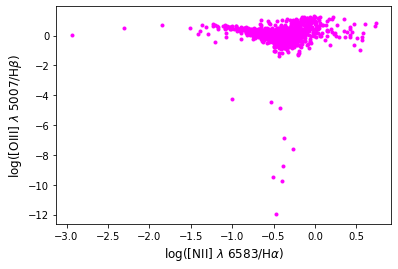

In [170]:
Nsize = 12
fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [171]:
x1=np.log10(np.arange(-50, 1, 0.01))
x2=np.log10(np.arange(-50, 2.5, 0.01))
y1=1.3 + 0.61/(x1-0.05) #kauffmann
y2=(0.61/(x2 -0.47))+1.19  #kewely

C:\Users\Jayde\AppData\Local\Temp\ipykernel_13556\3782894524.py:1: RuntimeWarning: invalid value encountered in log10
  x1=np.log10(np.arange(-50, 1, 0.01))
C:\Users\Jayde\AppData\Local\Temp\ipykernel_13556\3782894524.py:2: RuntimeWarning: invalid value encountered in log10
  x2=np.log10(np.arange(-50, 2.5, 0.01))


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

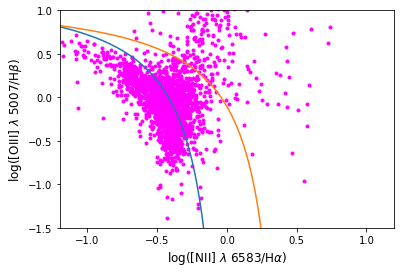

In [172]:

fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
plt.plot(x1,y1)
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [173]:

H, xedges, yedges = np.histogram2d(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'],range=[[-1.3,1.3],[-1.5,1.1]], bins=60)
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
if astro_smooth:
    kernel = Gaussian2DKernel(x_stddev=1)
    H=convolve(H,kernel)


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

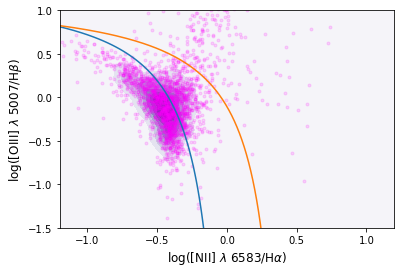

In [174]:
fig, ax = plt.subplots()
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples')
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta', alpha=0.15)
plt.plot(x1,y1, label='Kaufmann')
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

## 

### <span style='background :LightPink' > Creating Sample1

In [1555]:
sample1=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']<1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]
#sample1

In [1556]:
sample1=sample1[sample1['log(NII/Ha)']<0]

In [1557]:
#sample1
#plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'])

In [1558]:
sample1['log(NII/Ha)']

1      -0.370412
2      -0.367557
7      -0.333282
11     -0.454101
13     -0.740513
          ...   
5701   -0.401403
5707   -0.390901
5716   -0.429037
5722   -0.712849
5724   -0.727045
Name: log(NII/Ha), Length: 1255, dtype: float32

In [1559]:
#from astropy.table import Table
t=Table.from_pandas(sample1)

In [1560]:
#t.write('G:\\Project_AHopkins\Data\sample1.fits')

### <span style='background :LightPink' > Creating Sample2

In [1561]:
sample2=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']>1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]

In [1562]:
#(0.61/(x -0.47))+1.19
sample2=sample2[sample2['log(OIII/HB)']<1.19 + 0.61/(sample2['log(NII/Ha)']-0.47)]
#sample2

In [1563]:
#plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'])

In [1628]:
samp2=Table.from_pandas(sample2)
#samp2.write('G:\\Project_AHopkins\Data\sample2.csv', overwrite=True)

### <span style='background :LightPink' > Creating Sample3

In [1565]:
mask1= (EMU_GAMA_pd['log(OIII/HB)']>1.19 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.47))
mask2= (EMU_GAMA_pd['log(NII/Ha)']>0.1)


In [1566]:
sample3=EMU_GAMA_pd[mask1 | mask2]
#sample3

In [1567]:
#plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'])

In [1629]:
samp3=Table.from_pandas(sample3)
#samp3.write('G:\\Project_AHopkins\Data\sample3.csv', overwrite=True)

### <span style='background :LightPink' > Return to BPT

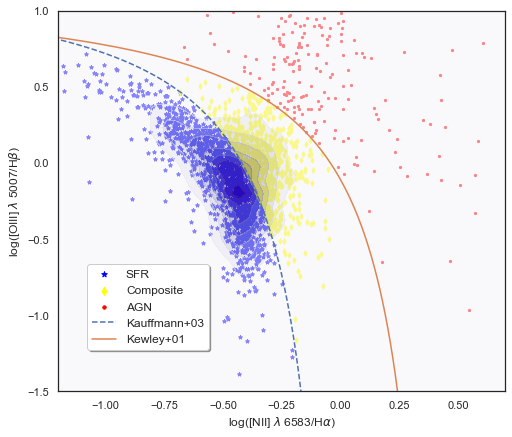

In [1569]:
fig, ax = plt.subplots(figsize=(8,7))

plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'], color='blue', marker='*', sizes=[15], label='SFR')
plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'], color='yellow',marker='d', sizes=[15], label='Composite')
plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'], color='red', marker='.',sizes=[20], label='AGN')


#plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='black')
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples',alpha=0.55)

plt.plot(x1,y1, linestyle='dashed', label='Kauffmann+03')
plt.plot(x2, y2, label='Kewley+01' )
ax.set_xlim(-1.2,0.7)
ax.set_ylim(-1.5,1)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
ax.legend(loc='upper right', bbox_to_anchor=(0.35, 0.35), fontsize=12, markerscale=1.5, shadow=True)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=12)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=12)
#plt.scatter(kaufmann_points[0],kaufmann_points[1], marker="*", alpha=0.3)
plt.savefig('E:\\BPT.png')

## <span style='background :LightPink' > Radio Flux to SFR

## <span style='background :LightPink' >  Calculate Distances

In [1570]:
z_1=np.array(sample1['Z_1'])

In [1571]:
print(cosmopy.api('z', z_1[0]))

{'z': '0.0759', 'a': '0.9294', 'dc': '322.9004 Mpc', 'dl': '347.4214 Mpc', 'da': '300.1100 Mpc', 'arc': '1454.9745 pc', 'tl': '1.0153 Gyr', 'ta': '12.7374 Gyr', 'dm': '37.7043'}


In [1572]:
sample1['Z_1']

1       0.07594
2       0.07579
7       0.27319
11      0.33424
13      0.17895
         ...   
5701    0.13444
5707    0.06332
5716    0.08315
5722    0.13208
5724    0.20657
Name: Z_1, Length: 1255, dtype: float32

In [1573]:
sample1=sample1[sample1['HA_FLUX']<100000]
sample1=sample1[sample1['HA_EW']>0]

In [1574]:
#pd.set_option('display.max_rows', None)
pd.reset_option('all')

D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
D:\anaconda\lib\site-packages\pandas\_config\config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [1575]:
sample1['HA_FLUX']

1        1356.179321
2         542.241394
7        1067.201904
11        265.482544
13        496.988495
            ...     
5701    22865.724609
5707      962.744385
5716    32747.402344
5722      210.414764
5724    13437.446289
Name: HA_FLUX, Length: 1249, dtype: float32

In [1576]:
#comoving method
DistLum=(1+sample1['Z_1'])*(sample1['comovingdist'])
DistLum

1        339.385101
2        338.671387
7       1388.686890
11      1753.819946
13       860.937561
           ...     
5701     627.897217
5707     279.604004
5716     373.661804
5722     615.844299
5724    1010.623352
Length: 1249, dtype: float32

In [1577]:
#Mpc to m
DistLum=DistLum*3.08567758128E+22
DistLum

1       1.047233e+25
2       1.045031e+25
7       4.285040e+25
11      5.411723e+25
13      2.656576e+25
            ...     
5701    1.937488e+25
5707    8.627678e+24
5716    1.153000e+25
5722    1.900297e+25
5724    3.118458e+25
Length: 1249, dtype: float32

In [1578]:
sample1.insert(2, "Luminosity_Distance", DistLum[:])

In [1579]:
from astropy.cosmology import WMAP9 as cosmo
cosmo.luminosity_distance(0.07594)

<Quantity 347.49888225 Mpc>

## <span style='background :LightPink' > Radio Luminosity


<div>
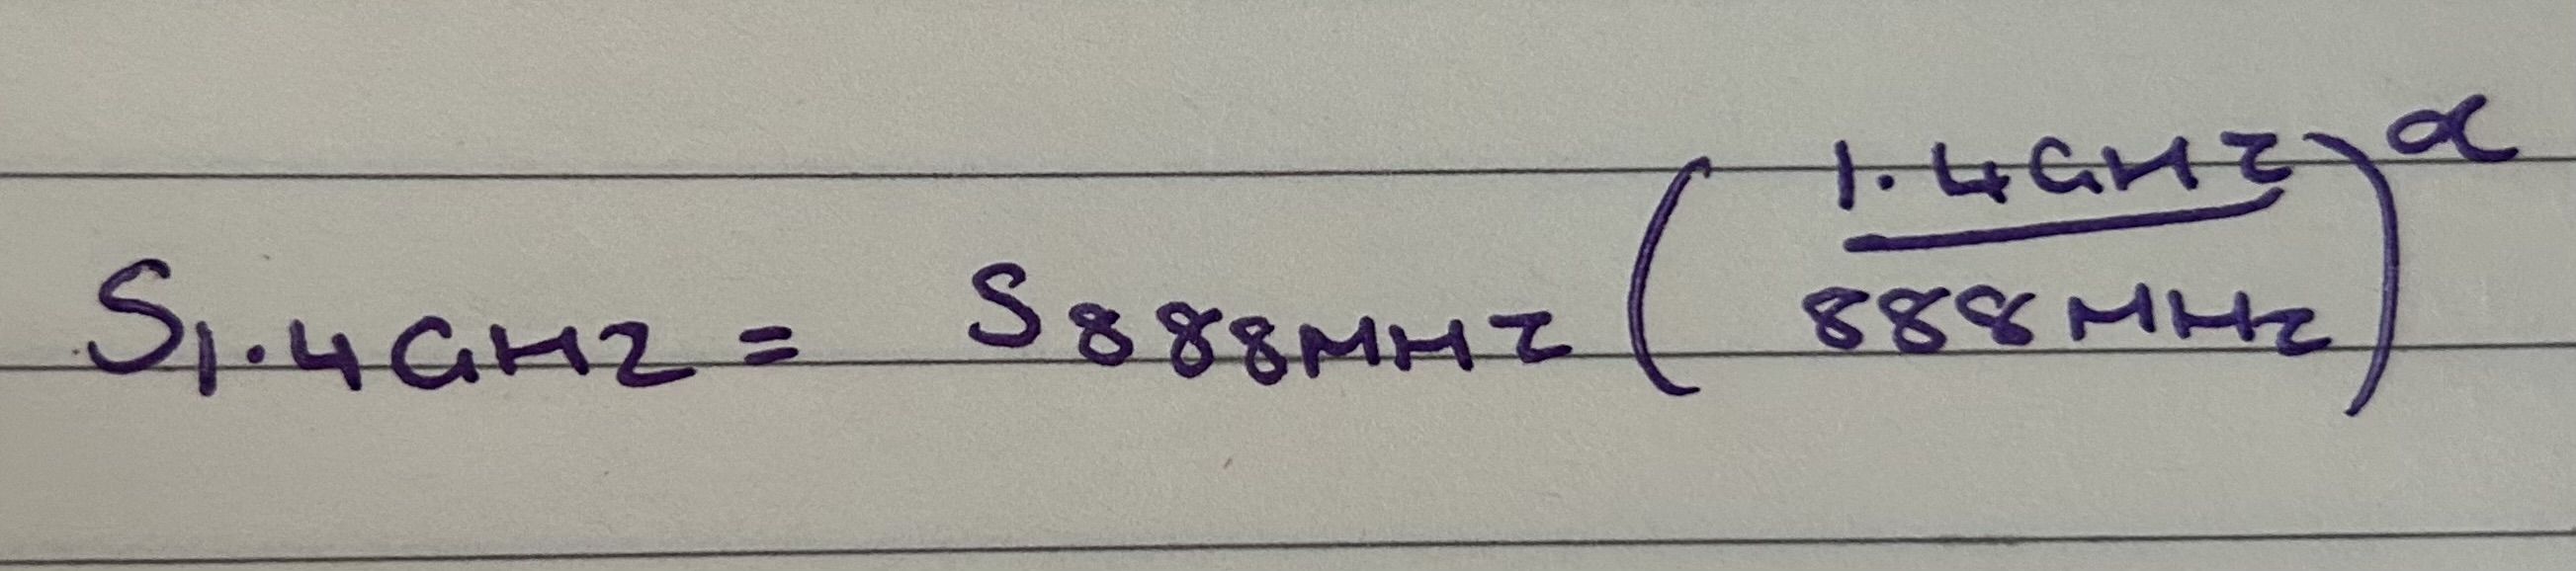
</div>



<div>
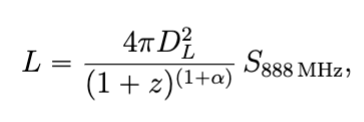
</div>

In [1580]:
Dl=np.array(sample1['Luminosity_Distance'])


In [1581]:
i=0
alpha=-0.7
flux888=np.array(sample1['Total_flux']*(10**(-26)))  #Janksy flux to W/Hz
flux14=np.array((sample1['Total_flux']*((1400/888)**alpha))*(10**(-26))) # 888 to 1.4 + Janksy flux to W/Hz
Dl2=[]
RadioLum14=[]
RadioLum888=[]
while i<1249:
 Dl2.append(float(Dl[i]**2))
 RadioLum888.append(((4*math.pi*Dl2[i])*flux888[i])/((1+z_1[i])**(1+alpha)))
 RadioLum14.append(((4*math.pi*Dl2[i])*flux14[i])/((1+z_1[i])**(1+alpha)))
 i=i+1

In [1582]:
RadioLum14

[5.456070137866776e+21,
 1.924564722835454e+21,
 6.971197291517459e+22,
 5.0014017551972354e+22,
 1.8247420862272973e+22,
 2.686722692466786e+22,
 1.3226606152160167e+22,
 1.5295372802176387e+22,
 4.9383221755260376e+22,
 8.212661733586207e+21,
 7.2345753412689e+21,
 5.338677703878192e+22,
 4.514174189329986e+22,
 4.785897881330757e+21,
 3.5246965865300636e+22,
 4.2589279235068595e+21,
 1.0416012540691601e+22,
 8.494225393934871e+22,
 4.787403285006543e+22,
 8.939792437113683e+21,
 1.01156573475289e+23,
 5.502932385215785e+21,
 1.5724860695384796e+22,
 1.0198670358691967e+22,
 2.23302408409928e+22,
 1.2094114571827355e+22,
 2.2183419614055865e+21,
 9.598181099155726e+21,
 6.58547716904789e+22,
 2.448157786406573e+22,
 2.0065764624349916e+22,
 9.5425483591278e+22,
 1.3712976489297977e+22,
 3.585392006587334e+20,
 2.0967376521003184e+22,
 2.904173478627089e+22,
 4.1291784509183125e+22,
 5.933154047235909e+21,
 7.905263776249835e+22,
 1.6377067995523789e+22,
 6.572295698539116e+22,
 3.248

In [1583]:
sample1.insert(2, "Radio_luminosity_14", RadioLum14[:])
sample1.insert(3, "Radio_luminosity_888", RadioLum888[:])


In [1584]:
sample1=sample1[sample1['Radio_luminosity_14']<9e24]

In [1585]:
sample1

,uberID_1,Z_1,Radio_luminosity_14,Radio_luminosity_888,Luminosity_Distance,log(NII/Ha),log(OIII/HB),comovingdist,nefffilt,snratio,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,5.456070e+21,7.503787e+21,1.047233e+25,-0.370412,-0.220083,315.431244,6.085568,109.384338,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,1.924565e+21,2.646873e+21,1.045031e+25,-0.367557,-0.580876,314.811798,6.085568,102.400002,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
7,340671039311876,0.27319,6.971197e+22,9.587556e+22,4.285040e+25,-0.333282,-0.733671,1090.714600,6.091957,96.000549,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,5.001402e+22,6.878477e+22,5.411723e+25,-0.454101,-0.695246,1314.471191,5.995922,99.549995,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
13,339680581501726,0.17895,1.824742e+22,2.509586e+22,2.656576e+25,-0.740513,0.275441,730.257935,6.517847,104.533318,...,-1.807700,-1.520700,1.344611e+08,1.780425e+08,1.103541e+08,2.428474e+08,2.653973e+10,2.352532e+10,3.274499e+10,339670402412343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,350701040104571,0.13444,2.174635e+22,2.990797e+22,1.937488e+25,-0.401403,-0.069131,553.486511,6.398734,111.359711,...,-1.637408,-1.386055,2.241911e+08,2.136106e+08,1.604303e+08,2.606047e+08,4.417676e+10,3.571403e+10,5.030358e+10,350701040104571
5707,350701057705467,0.06332,1.737352e+21,2.389398e+21,8.627678e+24,-0.390901,-0.841144,262.953766,6.019169,104.439766,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,8.562661e+21,1.177631e+22,1.153000e+25,-0.429037,-0.349897,344.976959,6.123384,106.104965,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,1.279551e+23,1.759779e+23,1.900297e+25,-0.712849,0.124575,543.993652,6.385637,93.500618,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


## <span style='background :LightPink' >  Radio Lum to SFR

## <span style='background :LightPink' > Bell 2003


<div>
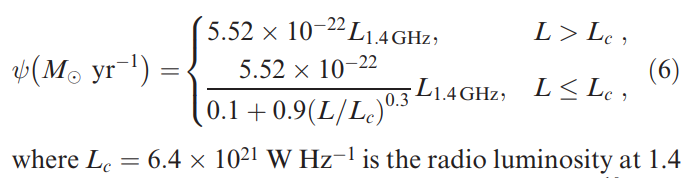
</div>

Is L our L_1.4?

Below is the version from A Hopkins 2003 10.1086/379608

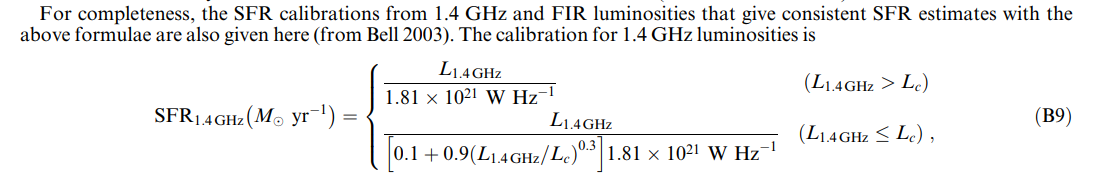


In [1586]:
# i=0
# Bell_SFR=[]
# while i<1248:
#     if RadioLum14[i]>(6.4e21):
#         Bell_SFR.append((5.5e-22)*RadioLum14[i])
#     else: 
#         Bell_SFR.append(((5.5e-22)*RadioLum14[i])/(0.1+0.9*((RadioLum14[i]/6.4e21)**0.3)))
#     i=i+1

In [1587]:
# i=0
# Bell_SFR=[]
# while i<1248:
#     if RadioLum14[i]>(6.4e21):
#         Bell_SFR.append((1/(1.81e21))*RadioLum14[i])
#     else: 
#         Bell_SFR.append((RadioLum14[i])/(1.81e21*(0.1+0.9*((RadioLum14[i]/(6.4e21))**0.3))))
#     i=i+1

In [1588]:
i=0
Bell_SFR=[]
for x in sample1['Radio_luminosity_14']:
    if x>(6.4e21):
        Bell_SFR.append((1/(1.81e21))*x)
    else: 
        Bell_SFR.append((x)/(1.81e21*(0.1+0.9*((x/(6.4e21))**0.3))))
    i=i+1

In [1589]:
RadioLum14

[5.456070137866776e+21,
 1.924564722835454e+21,
 6.971197291517459e+22,
 5.0014017551972354e+22,
 1.8247420862272973e+22,
 2.686722692466786e+22,
 1.3226606152160167e+22,
 1.5295372802176387e+22,
 4.9383221755260376e+22,
 8.212661733586207e+21,
 7.2345753412689e+21,
 5.338677703878192e+22,
 4.514174189329986e+22,
 4.785897881330757e+21,
 3.5246965865300636e+22,
 4.2589279235068595e+21,
 1.0416012540691601e+22,
 8.494225393934871e+22,
 4.787403285006543e+22,
 8.939792437113683e+21,
 1.01156573475289e+23,
 5.502932385215785e+21,
 1.5724860695384796e+22,
 1.0198670358691967e+22,
 2.23302408409928e+22,
 1.2094114571827355e+22,
 2.2183419614055865e+21,
 9.598181099155726e+21,
 6.58547716904789e+22,
 2.448157786406573e+22,
 2.0065764624349916e+22,
 9.5425483591278e+22,
 1.3712976489297977e+22,
 3.585392006587334e+20,
 2.0967376521003184e+22,
 2.904173478627089e+22,
 4.1291784509183125e+22,
 5.933154047235909e+21,
 7.905263776249835e+22,
 1.6377067995523789e+22,
 6.572295698539116e+22,
 3.248

In [1590]:
sample1.insert(2, "Bell_SFR", Bell_SFR[:])

## <span style='background :LightPink' > Condon 1992

$$ SFR(M\ge 5M_☉) = \frac{5.3\times 10^{-21}  L_{1.4GHz}}{(1.4)^{0.7}} $$


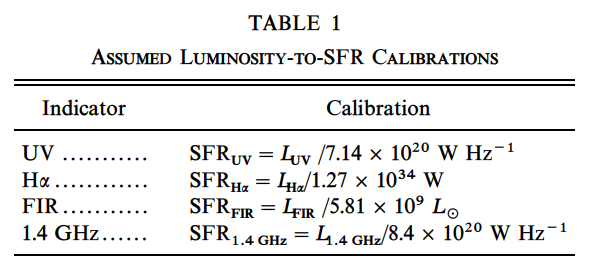


In [1591]:
#below A 2001 condon with calibration
Condon_SFR=(sample1['Radio_luminosity_14']/(8.4e20))

In [1592]:
sample1.insert(2, "Condon_SFR", Condon_SFR[:])
Condon_SFR

1         6.495322
2         2.291148
7        82.990444
11       59.540497
13       21.723120
           ...    
5701     25.888517
5707      2.068276
5716     10.193644
5722    152.327500
5724     25.448528
Name: Radio_luminosity_14, Length: 1248, dtype: float64

## <span style='background :LightPink' > Hα Flux to SFR

### <span style='background :LightPink' > Calculate L$_{H\alpha}$

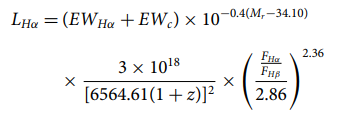


In [1593]:
Ha=sample1['HA_FLUX']
Hb=sample1['HB_FLUX']

In [1594]:
EW_Ha=sample1['HA_EW']
EW_HB=sample1['HB_EW']
EW_c= 2.5  #˚A from Hopkins(2003)  #EWc is the equivalent width correction for stellar absorption #Tania uses 2.5 from AHopkins 2013
Mr=sample1['absmag_r']
z=sample1['Z_1']

In [1595]:
SHa=(EW_Ha+EW_c)*(Ha/EW_Ha)
SHB=(EW_HB+EW_c)*(Hb/EW_HB)
BD=SHa/SHB

In [1596]:
Lum_HA=(EW_Ha + EW_c)*(10**(-0.4*(Mr-34.10)))*((3e18)/(6564.61*(1+z))**2)*((BD/2.86)**2.36)

In [1597]:
Lum_HA=np.array(Lum_HA)
Lum_HA

array([2.3474129e+34, 5.5809054e+33, 3.1430693e+35, ..., 1.7082865e+35,
       1.1627570e+34, 1.3423759e+35], dtype=float32)

In [1598]:
sample1.insert(2, "HA_Luminosity", Lum_HA[:])

## <span style='background :LightPink' > Ahmed 2024 - Really Kennicut 1998

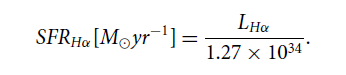
From Tanias^^ THIS IS REALLY KENNICUT 1998

In [1599]:
SFR_HA_Tan=1.27e-34*Lum_HA
SFR_HA_Tan

array([ 2.9812143,  0.708775 , 39.91698  , ..., 21.695238 ,  1.4767013,
       17.048174 ], dtype=float32)

In [1600]:
sample1.insert(2, "Ha_SFR", SFR_HA_Tan[:])

## <span style='background :LightPink' > Radio + Ha to SFR 

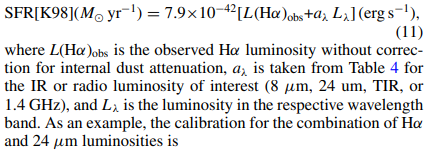

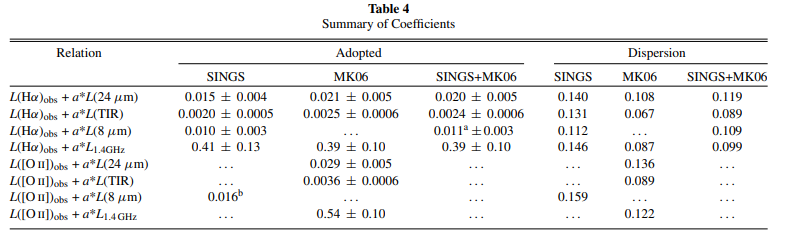

From 2009 paper

In [1601]:
# K09_SFR=((7.9e-42)*((Lum_HA*(1e7))+(0.39*sample1['Radio_luminosity_14']*(1e7))))

In [1602]:
K09_SFR=(7.9e-35)*((Lum_HA)+(0.39*sample1['Radio_luminosity_14']))

In [1603]:
K09_SFR

1        1.854456
2        0.440892
7       24.830248
11      11.886323
13       5.697464
          ...    
5701    11.018689
5707     1.681459
5716    13.495464
5722     0.918578
5724    10.604770
Name: Radio_luminosity_14, Length: 1248, dtype: float64

In [1604]:
sample1.insert(2, "K09_SFR", K09_SFR[:])


## <span style='background :LightPink' > Ha + Dust Mass SFR (Tanias) </span>

In [1605]:
Dust_Mass=sample1['DustMass_bestfit']
Dust_Mass

1       9.836123e+07
2       9.108934e+06
7       2.881511e+08
11      3.820698e+08
13      1.344611e+08
            ...     
5701    2.241911e+08
5707    5.315158e+07
5716    6.286991e+07
5722    5.518692e+06
5724    3.100192e+08
Name: DustMass_bestfit, Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate $\tau$

$\tau^l_B = 2.303\log(\frac{\text{H}\alpha}{\text{H}\beta}) - 1.0508$

In [1606]:
tau=2.303*np.log10(Ha/Hb)-1.0508
tau

1       1.028563
2       0.227932
7       1.017851
11      0.874798
13      0.580236
          ...   
5701    0.926170
5707    0.845029
5716    1.838001
5722    0.563942
5724    0.899251
Length: 1248, dtype: float32

### <span style='background :LightPink' > Calculate H$_{dust}$

$H_{\rm dust} = \frac{M_d}{10^{\tau^l_B}}$

In [1607]:
H_dust=Dust_Mass/(10**tau)
H_dust

1       9.210020e+06
2       5.389341e+06
7       2.765469e+07
11      5.097351e+07
13      3.534764e+07
            ...     
5701    2.657349e+07
5707    7.594290e+06
5716    9.129394e+05
5722    1.506241e+06
5724    3.909647e+07
Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate L$_{H\alpha,improved}$

In [1608]:
L_Ha_impr=(10**((np.log10(H_dust)-22.564)/(1.165)))*(Lum_HA)
L_Ha_impr

1       9.555539e+20
2       1.434189e+20
7       3.287744e+22
11      2.660275e+22
13      9.313083e+21
            ...     
5701    1.409872e+22
5707    7.342036e+20
5716    9.562679e+20
5722    1.000374e+20
5724    1.890123e+22
Length: 1248, dtype: float64

In [1609]:
np.log10(L_Ha_impr/Lum_HA)

1      -13.390334
2      -13.590098
7      -12.980456
11     -12.752494
13     -12.888961
          ...    
5701   -12.995323
5707   -13.462243
5716   -14.251981
5722   -14.065327
5724   -12.851384
Length: 1248, dtype: float64

### <span style='background :LightPink' > Calculate SFR

In [1610]:
#This is the incorrect Method
# Dust_SFR=(7.9e-35)*(Lum_HA+(0.39e13*L_Ha_impr))
# Dust_SFR

In [1611]:
#This is apparently correct
# Dust_SFR=L_Ha_impr*(1.27e-34)
# Dust_SFR

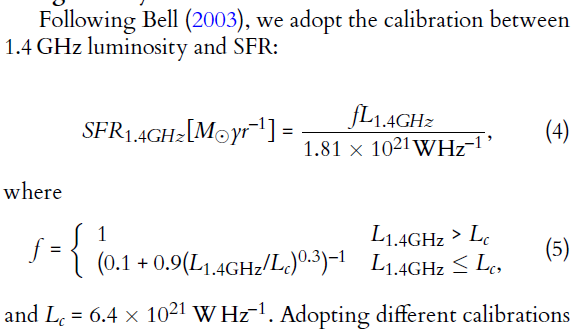

In [1612]:
i=0
Dust_SFR=[]
for x in L_Ha_impr:
    if x>(6.4e21):
        Dust_SFR.append((1/(1.81e21))*x)
    else: 
        Dust_SFR.append((x)/(1.81e21*(0.1+0.9*((x/(6.4e21))**0.3))))
    i=i+1

In [1613]:
Dust_SFR

[0.8673023482757928,
 0.20422672273201944,
 18.16433041060701,
 14.697650786260095,
 5.145349613880713,
 12.493719016232355,
 5.816420883522156,
 1.9040575827100585,
 13.100959728108428,
 2.5990015975837553,
 2.3484063309834458,
 34.31976658254771,
 26.489855613453955,
 2.0843122236525993,
 22.21212451707481,
 3.261278109854188,
 2.787295556973718,
 32.699325670110014,
 4.583838314833424,
 3.7996789726263356,
 36.512490849760596,
 3.0745606791993176,
 3.7279077753005656,
 1.6867216034976862,
 6.305679169307314,
 1.9643249288380036,
 1.1127567447403213,
 1.7273604260114948,
 11.31521714653603,
 3.6567404634995797,
 1.7761734541556236,
 10.810272155569306,
 9.159124025821473,
 0.08505498304765688,
 2.114536064618597,
 2.3104521624848444,
 10.780159421661331,
 0.5880829787949141,
 26.59132052282757,
 7.346168626798715,
 17.31278474817497,
 16.93346859808265,
 6.380426532251269,
 46.78812954576719,
 2.5886726611845674,
 0.09737905304848829,
 2.674183829662611,
 9.077612379214363,
 8.114962

In [1614]:
sample1.insert(2, "Dust_SFR", Dust_SFR[:])

### <span style='background :LightPink' >Final Cuts

In [1615]:
sample1=sample1[sample1['HA_Luminosity']>2e-13]
sample1

,uberID_1,Z_1,Dust_SFR,K09_SFR,Ha_SFR,HA_Luminosity,Condon_SFR,Bell_SFR,Radio_luminosity_14,Radio_luminosity_888,...,Zgas_16,Zgas_84,DustMass_bestfit,DustMass_50,DustMass_16,DustMass_84,DustLum_50,DustLum_16,DustLum_84,uberID
1,339680398800078,0.07594,0.867302,1.854456,2.981214,2.347413e+34,6.495322,3.146785,5.456070e+21,7.503787e+21,...,-1.720073,-1.366063,9.836123e+07,1.466322e+08,1.168056e+08,1.785403e+08,2.262007e+10,2.029742e+10,2.509972e+10,339680398800078
2,339670202310631,0.07579,0.204227,0.440892,0.708775,5.580905e+33,2.291148,1.461358,1.924565e+21,2.646873e+21,...,-1.574576,-1.353993,9.108934e+06,1.373287e+07,6.600075e+06,2.341676e+07,7.977917e+09,6.816998e+09,9.065190e+09,339680381000017
7,340671039311876,0.27319,18.164330,24.830248,39.916981,3.143069e+35,82.990444,38.514902,6.971197e+22,9.587556e+22,...,-1.510098,-1.300000,2.881511e+08,2.510421e+08,1.054192e+08,4.694597e+08,9.949578e+10,8.466617e+10,1.159159e+11,340671039311876
11,339670227412295,0.33424,14.697651,11.886323,19.108393,1.504598e+35,59.540497,27.632054,5.001402e+22,6.878477e+22,...,-3.260671,-2.243432,3.820698e+08,3.671545e+08,2.016374e+08,5.695889e+08,1.547725e+11,1.301521e+11,1.909556e+11,339680406501681
13,339680581501726,0.17895,5.145350,5.697464,9.159215,7.211980e+34,21.723120,10.081448,1.824742e+22,2.509586e+22,...,-1.807700,-1.520700,1.344611e+08,1.780425e+08,1.103541e+08,2.428474e+08,2.653973e+10,2.352532e+10,3.274499e+10,339670402412343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,350701040104571,0.13444,7.789348,11.018689,17.713587,1.394771e+35,25.888517,12.014560,2.174635e+22,2.990797e+22,...,-1.637408,-1.386055,2.241911e+08,2.136106e+08,1.604303e+08,2.606047e+08,4.417676e+10,3.571403e+10,5.030358e+10,350701040104571
5707,350701057705467,0.06332,0.711596,1.681459,2.703106,2.128430e+34,2.068276,1.354529,1.737352e+21,2.389398e+21,...,-1.819582,-1.493973,5.315158e+07,5.117048e+07,4.133876e+07,6.083873e+07,6.677293e+09,6.004131e+09,7.386367e+09,350701057705467
5716,350700902306866,0.08315,0.867788,13.495464,21.695238,1.708287e+35,10.193644,4.730752,8.562661e+21,1.177631e+22,...,-1.517454,-1.300000,6.286991e+07,3.864522e+07,1.809681e+07,8.193255e+07,2.193433e+10,1.652379e+10,3.027521e+10,350700902306866
5722,350701026307521,0.13208,0.154174,0.918578,1.476701,1.162757e+34,152.327500,70.693425,1.279551e+23,1.759779e+23,...,-1.793917,-1.401841,5.518692e+06,7.674942e+05,1.261835e+05,8.542194e+06,7.826745e+09,6.360885e+09,9.456894e+09,350701026307521


In [1616]:
t=Table.from_pandas(sample1)
t.write('G:\\Project_AHopkins\Data\sample1_final.fits', overwrite=True)

## <span style='background :LightPink' >  Import Prospect Data

In [1617]:
EMU_GAMA_DUST_PROSPECT=fits.open('G:\Project_AHopkins\Data\Sample1XProspect\EMU_GAMA_DUST_PROSPECT', ignore_missing_simple=True)
EMU_GAMA_DUST_PROSPECT=Table(EMU_GAMA_DUST_PROSPECT[1].data)
EMU_GAMA_DUST_PROSPECT_pd=EMU_GAMA_DUST_PROSPECT.to_pandas()
EMU_GAMA_DUST_PROSPECT_pd


,uberID_1,Z_1,Dust_SFR,K98_SFR,Ha_SFR,HA_Luminosity,Condon_SFR,Bell_SFR,Radio_luminosity_14,Radio_luminosity_888,...,uberID,filenames,SPECID_SED,SFRpeak,SFRmedian,dustmasstot,masstot,z_SED,GroupID,GroupSize
0,339680398800078,0.07594,10.802400,10.802400,17.365884,1.367392e+35,6.495322,3.132624,5.456070e+21,7.503787e+21,...,339680398800078,G23_Y7_042_233_EMU_data,G23_Y7_042_233,8.79717909647571,3.74614276864125,433201.375341709,77970260222.0387,0.07594,1,2
1,339680398800078,0.07594,10.802400,10.802400,17.365884,1.367392e+35,6.495322,3.132624,5.456070e+21,7.503787e+21,...,339680398800078,G23_Y7_042_233_NoEMU_data,G23_Y7_042_233,9.32296602587639,3.03791344768464,344596.689913061,81557563035.1826,0.07594,1,2
2,339670202310631,0.07579,0.813347,0.813347,1.307532,1.029553e+34,2.291148,1.454782,1.924565e+21,2.646873e+21,...,339680381000017,G23_Y7_022_153_EMU_data,G23_Y7_022_153,2.29012472248803,1.16551324625226,143659.182601959,11538257870.5085,0.07579,2,2
3,339670202310631,0.07579,0.813347,0.813347,1.307532,1.029553e+34,2.291148,1.454782,1.924565e+21,2.646873e+21,...,339680381000017,G23_Y7_022_153_NoEMU_data,G23_Y7_022_153,2.19263359465455,1.21433097087935,146582.926502461,11724827892.7218,0.07579,2,2
4,340671039311876,0.27319,61.508272,61.508272,98.880387,7.785857e+35,82.990444,38.341585,6.971197e+22,9.587556e+22,...,340671039311876,G23_Y5_077_079_EMU_data,G23_Y5_077_079,384.236374072981,0.520275496728214,699574931.57982,298683378544.806,0.27319,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2489,350700902306866,0.08315,155.241942,155.241942,249.566160,1.965088e+36,10.193644,1.348434,8.562661e+21,1.177631e+22,...,350700902306866,2dF125301_NoEMU_data,2dF125301,14.3273732977464,5.86075376448039,808950.523242946,68435954898.335,0.08315,1245,2
2490,350701026307521,0.13208,2.129130,2.129130,3.422778,2.695101e+34,152.327500,4.709463,1.279551e+23,1.759779e+23,...,350701026307521,G23_Y7_033_302_EMU_data,G23_Y7_033_302,1.60524910827014,1.56593792028993,390145.973987535,11029263095.185,0.13208,1246,2
2491,350701026307521,0.13208,2.129130,2.129130,3.422778,2.695101e+34,152.327500,4.709463,1.279551e+23,1.759779e+23,...,350701026307521,G23_Y7_033_302_NoEMU_data,G23_Y7_033_302,1.44022286019162,1.39437157461513,4050520.12678855,11152202327.355,0.13208,1246,2
2492,350701003108055,0.20657,21.275876,21.275876,34.202991,2.693149e+35,25.448528,70.375305,2.137676e+22,2.939967e+22,...,350701003108055,2dF125329_EMU_data,2dF125329,19.8669437461955,13.2448695560799,89830494.5172099,22570644876.6351,0.20657,1247,2


In [1618]:
Prospect_Radio=EMU_GAMA_DUST_PROSPECT_pd.iloc[::2]
Prospect_Radio_SFR=Prospect_Radio['SFRpeak']
Prospect_Radio_SFR=Prospect_Radio_SFR.values.astype(float)

Prospect_NoRadio=EMU_GAMA_DUST_PROSPECT_pd.iloc[1::2]
Prospect_NoRadio_SFR=Prospect_NoRadio['SFRpeak']
Prospect_NoRadio_SFR=Prospect_NoRadio_SFR.values.astype(float)


## <span style='background :LightPink' > Corner Plot

Goal:
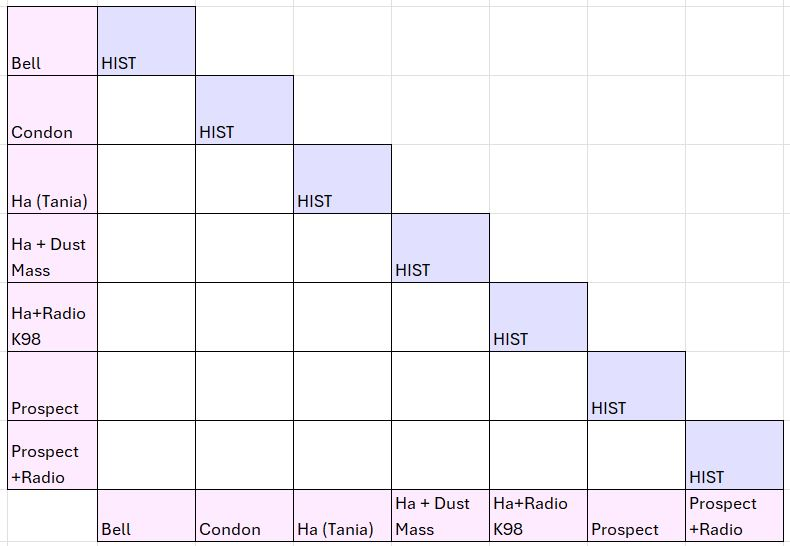

In [1619]:
SFR_all= sample1[['Bell_SFR', 'Condon_SFR', 'Ha_SFR', 'K09_SFR', 'Dust_SFR']].copy()

In [1620]:
## ADD PROSPECT
SFR_all.insert(5, "Prospect_NoRadio_SFR", Prospect_NoRadio_SFR[:])
SFR_all.insert(6, "Prospect_Radio_SFR", Prospect_Radio_SFR[:])

In [1621]:
SFR_all

,Bell_SFR,Condon_SFR,Ha_SFR,K09_SFR,Dust_SFR,Prospect_NoRadio_SFR,Prospect_Radio_SFR
1,3.146785,6.495322,2.981214,1.854456,0.867302,9.322966,8.797179
2,1.461358,2.291148,0.708775,0.440892,0.204227,2.192634,2.290125
7,38.514902,82.990444,39.916981,24.830248,18.164330,977.249868,384.236374
11,27.632054,59.540497,19.108393,11.886323,14.697651,30.406298,25.291462
13,10.081448,21.723120,9.159215,5.697464,5.145350,4.543822,4.412973
...,...,...,...,...,...,...,...
5701,12.014560,25.888517,17.713587,11.018689,7.789348,10.497985,10.660763
5707,1.354529,2.068276,2.703106,1.681459,0.711596,1.655408,1.649750
5716,4.730752,10.193644,21.695238,13.495464,0.867788,14.327373,11.780931
5722,70.693425,152.327500,1.476701,0.918578,0.154174,1.440223,1.605249


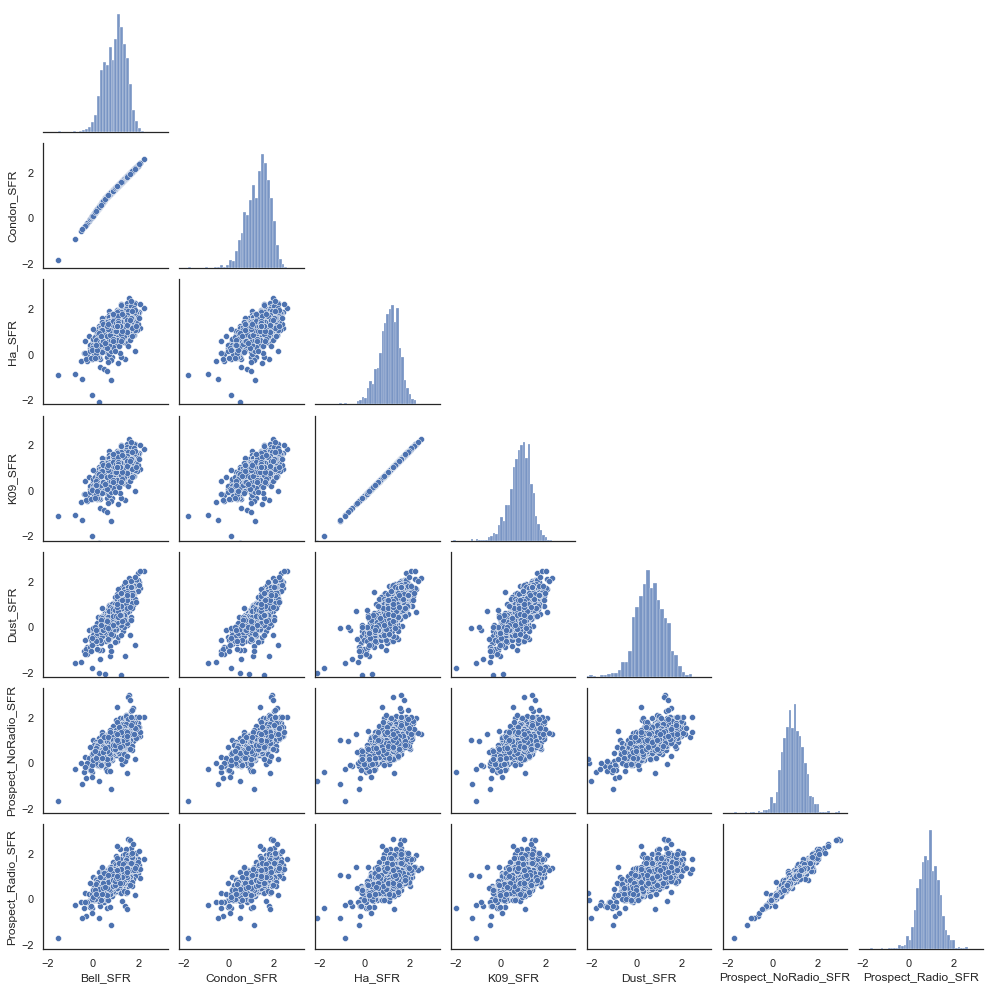

In [1622]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

#sns_plot.savefig('Corner.png')
#ns.set_theme(font_scale=12)

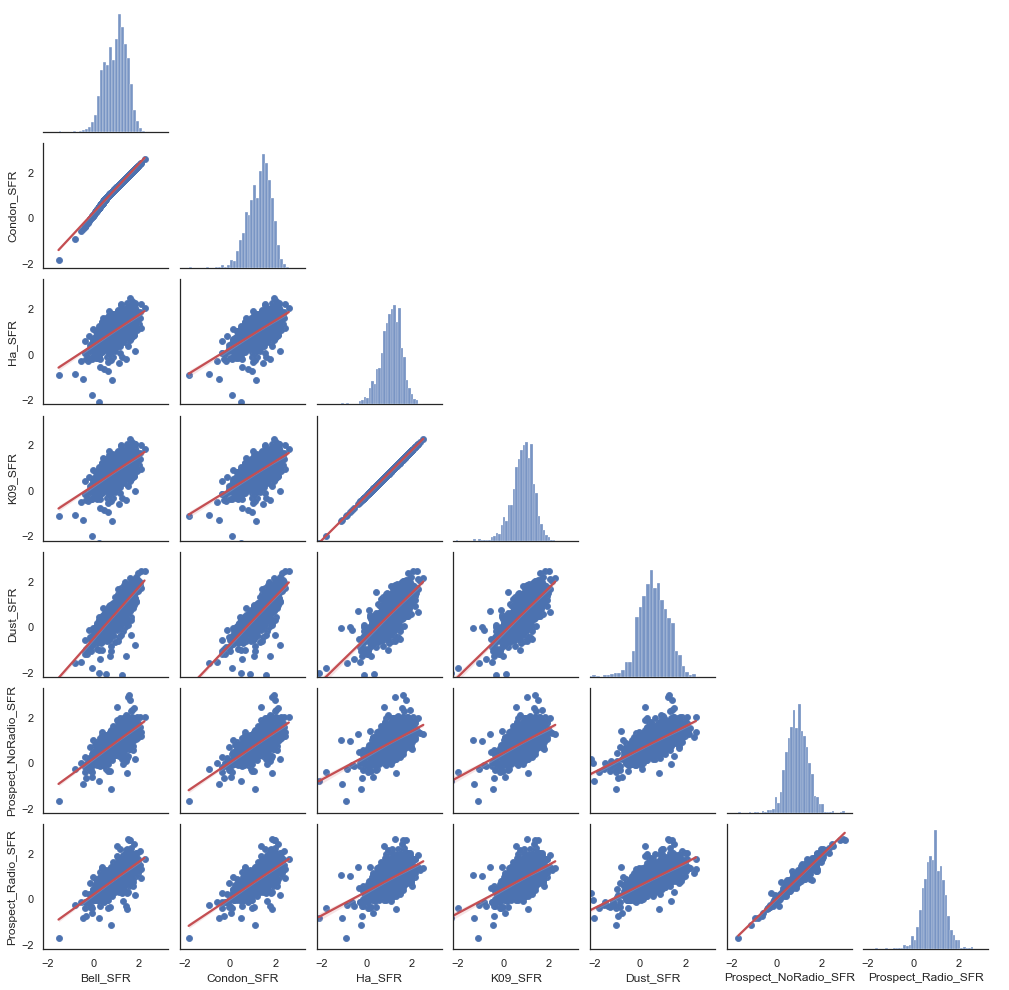

In [1623]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2)
sns_plot.map_lower(sns.regplot, line_kws=dict(color="r"))
sns_plot.add_legend()
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

In [1624]:
def plot_unity(xdata, ydata, **kwargs):
    mn = min(-2.2, -2.2)
    mx = max(3.3, 3.3)
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='dotted', linewidth=2.0, alpha=0.2)


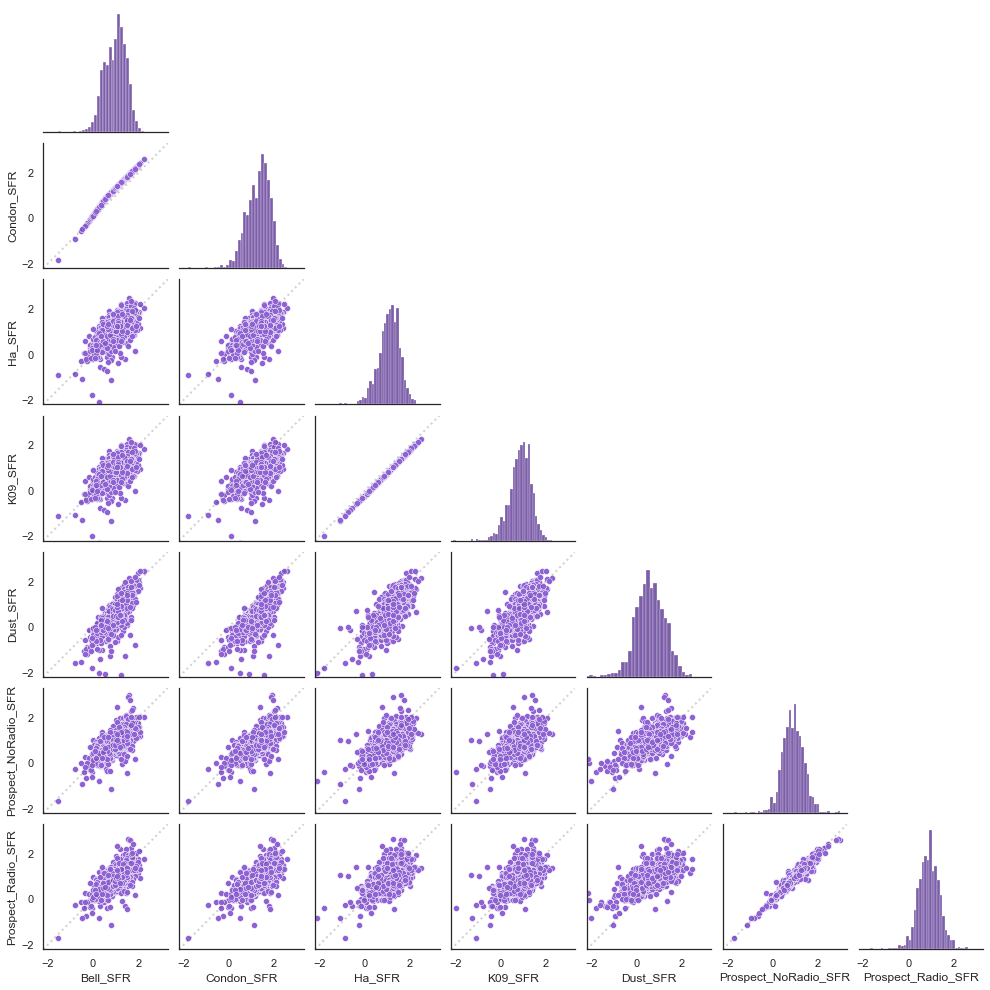

In [1625]:
sns_plot=sns.pairplot(np.log10(SFR_all), corner=True, height=2, plot_kws={'color':'#8e61d4'}, diag_kws= {'color': '#50288d'})
sns_plot.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))
sns_plot.map_lower(plot_unity)
#sns_plot.savefig('Corner.png')

In [1626]:
#sns_plot.savefig('Cornerlines.png')

## <span style='background :LightPink' > LOBF Gradient and Stats

In [779]:
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b


In [795]:
mbs=[]
mbs.append(['BellvsCondon',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])])
mbs.append(['BellvsHa',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['BellvsK09',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['K09_SFR'])])
mbs.append(['BellvsDust',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['BellvsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['BellvsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['CondonvsHa',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])])
mbs.append(['CondonvsK09',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['K09_SFR'])])
mbs.append(['CondonvsDust',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['CondonvsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['CondonvsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'])])


mbs.append(['HavsK09',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['K09_SFR'])])
mbs.append(['HavsDust',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['HavsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['HavsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['K09vsDust',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Dust_SFR'])])
mbs.append(['K09vsProspect_NoRadio',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'])])
mbs.append(['K09vsProspect_Radio',best_fit_slope_and_intercept(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'])])

mbs.append(['Prospect_NoRadiovsProspect_Radio',best_fit_slope_and_intercept(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'])])


In [796]:
mbs

[['BellvsCondon', (2.1606517598262087, -0.21891701236166483)],
 ['BellvsHa', (0.6664750204861188, 9.208357790489943)],
 ['BellvsK09', (0.4145789604764642, 5.728033760227642)],
 ['BellvsDust', (0.9220627221645279, 3.393821487398622)],
 ['BellvsProspect_NoRadio', (0.7317755696714463, 4.303211710994644)],
 ['BellvsProspect_Radio', (0.640175930218875, 4.701211679846715)],
 ['CondonvsHa', (0.3088644876650329, 9.261866926015925)],
 ['CondonvsK09', (0.19212830832283545, 5.761318971316204)],
 ['CondonvsDust', (0.4268433163243114, 3.4840829394332022)],
 ['CondonvsProspect_NoRadio', (0.33887860177821827, 4.370566138513832)],
 ['CondonvsProspect_Radio', (0.2965004147904566, 4.758721438232147)],
 ['HavsK09', (0.6220472601730547, 2.6110239303989147e-08)],
 ['HavsDust', (0.9077611314037974, 0.1547636167801194)],
 ['HavsProspect_NoRadio', (0.3016552739492232, 10.095695398269731)],
 ['HavsProspect_Radio', (0.26481636433047173, 9.75023843550171)],
 ['K09vsDust', (1.459312159846002, 0.1547635913458656)]

## <span style='background :LightPink' > Scatter


-Find distances to 1to1 line  

-Plot  

-fit Gaussian  

-find sd

In [901]:
def point_to_line_distance(x0, y0, slope, intercept):
    # Calculate the perpendicular distance
    distance = (slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)
    return distance

In [1529]:
# #distance to LOBF

dist_LOBF={'BellvsCondon': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], mbs[0][1][0], mbs[0][1][1]),
        'BellvsHa': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'], mbs[1][1][0], mbs[1][1][1]),
        'BellvsK09': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['K09_SFR'], mbs[2][1][0], mbs[2][1][1]),
        'BellvsDust': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'], mbs[3][1][0], mbs[3][1][1]),
        'BellvsProspect_NoRadio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[4][1][0], mbs[4][1][1]),
        'BellvsProspect_Radio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[5][1][0], mbs[5][1][1]),
      
        'CondonvsHa': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'], mbs[6][1][0], mbs[6][1][1]),
        'CondonvsK09': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['K09_SFR'], mbs[7][1][0], mbs[7][1][1]),
        'CondonvsDust': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'], mbs[8][1][0], mbs[8][1][1]),
        'CondonvsProspect_NoRadio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[9][1][0], mbs[9][1][1]),
        'CondonvsProspect_Radio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[10][1][0], mbs[10][1][1]),
      
        'HavsK09':point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['K09_SFR'], mbs[11][1][0], mbs[11][1][1]),
        'HavsDust': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'], mbs[12][1][0], mbs[12][1][1]),
        'HavsProspect_NoRadio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[13][1][0], mbs[13][1][1]),
        'HavsProspect_Radio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[14][1][0], mbs[14][1][1]),
      
        'K09vsDust': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Dust_SFR'], mbs[15][1][0], mbs[15][1][1]),
        'K09vsProspect_NoRadio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'], mbs[16][1][0], mbs[16][1][1]),
        'K09vsProspect_Radio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[17][1][0], mbs[17][1][1]),
      
        'Prospect_NoRadiovsProspect_Radio': point_to_line_distance(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'], mbs[18][1][0], mbs[18][1][1])
     
     }




dist_LOBF_df=pd.DataFrame(dist_LOBF)
#dist_LOBF_df

In [1457]:
#Distance to the 1to1 line
dist={'BellvsCondon': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'], 1, 0),
        'BellvsHa': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'], 1, 0),
        'BellvsK09': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['K09_SFR'], 1, 0),
        'BellvsDust': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'BellvsProspect_NoRadio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'BellvsProspect_Radio': point_to_line_distance(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'CondonvsHa': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'], 1, 0),
        'CondonvsK09': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['K09_SFR'], 1, 0),
        'CondonvsDust': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'CondonvsProspect_NoRadio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'CondonvsProspect_Radio': point_to_line_distance(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'HavsK09':point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['K09_SFR'], 1, 0),
        'HavsDust': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'HavsProspect_NoRadio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'HavsProspect_Radio': point_to_line_distance(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'K09vsDust': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Dust_SFR'], 1, 0),
        'K09vsProspect_NoRadio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'], 1, 0),
        'K09vsProspect_Radio': point_to_line_distance(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0),
      
        'Prospect_NoRadiovsProspect_Radio': point_to_line_distance(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'], 1, 0)
     
     }
dist_df=pd.DataFrame(dist)
dist_df

,BellvsCondon,BellvsHa,BellvsK09,BellvsDust,BellvsProspect_NoRadio,BellvsProspect_Radio,CondonvsHa,CondonvsK09,CondonvsDust,CondonvsProspect_NoRadio,CondonvsProspect_Radio,HavsK09,HavsDust,HavsProspect_NoRadio,HavsProspect_Radio,K09vsDust,K09vsProspect_NoRadio,K09vsProspect_Radio,Prospect_NoRadiovsProspect_Radio
1,-2.367773,0.117076,0.913814,1.611837,-4.367220,-3.995432,2.484849,3.281587,3.979611,-1.999447,-1.627659,0.796738,1.494761,-4.484296,-4.112508,0.698023,-5.281034,-4.909246,0.371788
2,-0.586750,0.532157,0.721579,0.888926,-0.517090,-0.586026,1.118907,1.308329,1.475677,0.069661,0.000724,0.189422,0.356769,-1.049246,-1.118183,0.167347,-1.238669,-1.307605,-0.068937
7,-31.448957,-0.991419,9.676512,14.390027,-663.785860,-244.461997,30.457538,41.125469,45.838984,-632.336903,-213.013040,10.667931,15.381447,-662.794441,-243.470578,4.713515,-673.462372,-254.138509,419.323863
11,-22.562677,6.027139,11.133913,9.146004,-1.961687,1.655048,28.589815,33.696590,31.708681,20.600990,24.217725,5.106774,3.118866,-7.988825,-4.372090,-1.987909,-13.095600,-9.478865,3.616735
13,-8.231905,0.652117,3.099945,3.490349,3.915693,4.008217,8.884022,11.331850,11.722254,12.147598,12.240123,2.447827,2.838231,3.263576,3.356100,0.390404,0.815748,0.908273,0.092525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5701,-9.810369,-4.029820,0.704188,2.987676,1.072381,0.957279,5.780548,10.514556,12.798045,10.882749,10.767648,4.734008,7.017496,5.102201,4.987100,2.283488,0.368193,0.253092,-0.115101
5707,-0.504695,-0.953587,-0.231174,0.454622,-0.212754,-0.208753,-0.448892,0.273521,0.959318,0.291942,0.295943,0.722413,1.408210,0.740834,0.744835,0.685797,0.018421,0.022422,0.004001
5716,-3.862848,-11.995703,-6.197587,2.731528,-6.785836,-4.985230,-8.132856,-2.334739,6.594376,-2.922988,-1.122382,5.798116,14.727231,5.209867,7.010474,8.929115,-0.588249,1.212357,1.800606
5722,-57.724008,48.943615,49.338268,49.878783,48.969409,48.852718,106.667623,107.062275,107.602790,106.693417,106.576725,0.394653,0.935168,0.025794,-0.090897,0.540515,-0.368859,-0.485550,-0.116691


### <span style='background :LightPink' > Plots!


D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings

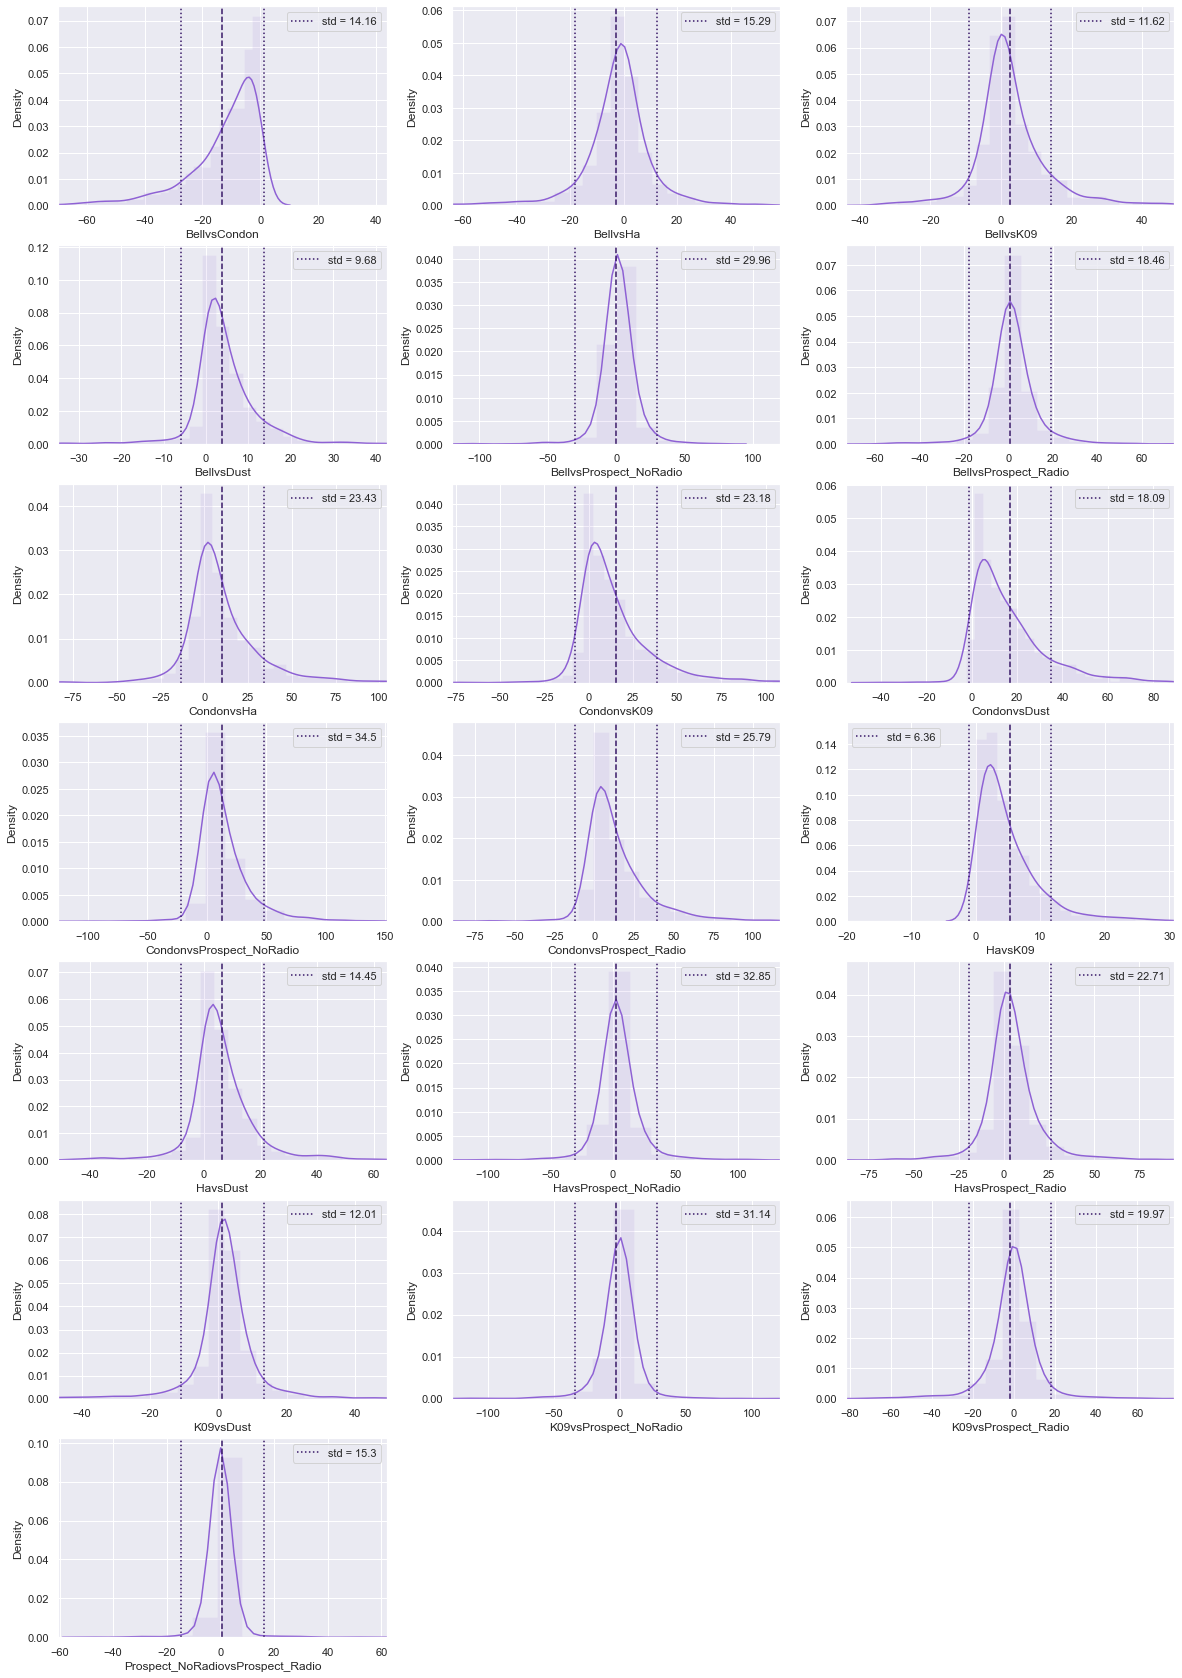

In [1485]:

fig, axes = plt.subplots(7,3, figsize=(20, 30))
for name, ax in zip(dist_df.columns.values, axes.flatten()):
    sns.distplot(dist_df[name],
                 kde_kws={"color": "#8e61d4", "lw": 1.5},
                 hist_kws={"histtype": "stepfilled", "linewidth": 1, "alpha": 0.1, "color": "#8e61d4"},
                 norm_hist=True,  
                 ax=ax)
    ax.axvline(dist_df[name].mean()-dist_df[name].std(), linestyle=':', color='#361666', label=("std = {}".format(round(dist_df[name].std(),2))))
    ax.axvline(dist_df[name].mean()+dist_df[name].std(), linestyle=':', color='#361666')
    ax.axvline(dist_df[name].mean(), linestyle='--', color='#361666')
    ax.set_xlim(dist_df[name].mean()-4*dist_df[name].std(), dist_df[name].mean()+4*dist_df[name].std() )
    ax.legend()
    
fig.delaxes(axes[-1, -1])
fig.delaxes(axes[-1, -2])



In [1464]:
std=[]
for name in dist_df.columns.values:
     std.append(["{}".format(name), round(dist_df[name].std(),2)])
     #print(name)
    
std

[['BellvsCondon', 14.16],
 ['BellvsHa', 15.29],
 ['BellvsK09', 11.62],
 ['BellvsDust', 9.68],
 ['BellvsProspect_NoRadio', 29.96],
 ['BellvsProspect_Radio', 18.46],
 ['CondonvsHa', 23.43],
 ['CondonvsK09', 23.18],
 ['CondonvsDust', 18.09],
 ['CondonvsProspect_NoRadio', 34.5],
 ['CondonvsProspect_Radio', 25.79],
 ['HavsK09', 6.36],
 ['HavsDust', 14.45],
 ['HavsProspect_NoRadio', 32.85],
 ['HavsProspect_Radio', 22.71],
 ['K09vsDust', 12.01],
 ['K09vsProspect_NoRadio', 31.14],
 ['K09vsProspect_Radio', 19.97],
 ['Prospect_NoRadiovsProspect_Radio', 15.3]]

### <span style='background :LightPink' > Scatter Diagram

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


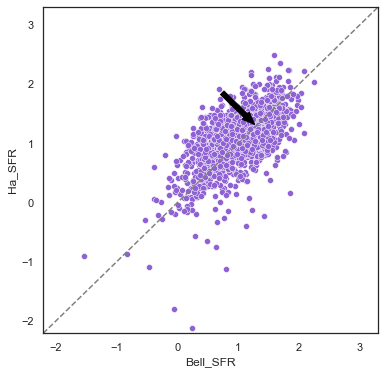

In [1490]:
plt.figure( figsize=(6,6))
g=sns.scatterplot(np.log10(SFR_all['Bell_SFR']), np.log10(SFR_all['Ha_SFR']), color="#8e61d4")
g.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))

scatx=np.arange(-2.2,3.4,0.1)
plt.plot(scatx, scatx, color='grey', alpha=1, linestyle='--')

#plt.plot((0.717505,1.298),(1.880142,1.298), marker='*')
#plt.arrow(0.717505,1.880142, 0.500495, -0.502142, head_width = 0.2, width = 0.07, color='black')
arr = mpatches.FancyArrowPatch((0.717505,1.880142),(1.298,1.298), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
g.add_patch(arr)



D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


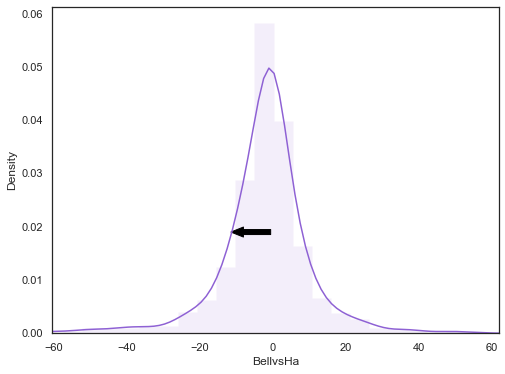

In [1491]:
import matplotlib.patches as mpatches
plt.figure(figsize=(8,6))
g=sns.distplot(dist_df['BellvsHa'],
                 kde_kws={"color": "#8e61d4", "lw": 1.5},
                 hist_kws={"histtype": "stepfilled", "linewidth": 1, "alpha": 0.1, "color": "#8e61d4"},
                 norm_hist=True)
g.set_xlim(dist_df[name].mean()-4*dist_df[name].std(), dist_df[name].mean()+4*dist_df[name].std() )

#plt.plot((0,-11.99),(0.015,0.015), marker='<', color='black')
#plt.arrow(0,0.02, -11.99, 0.003, head_width = 0.01, width = 0.004, color='black')
arr = mpatches.FancyArrowPatch((0,0.019),(-11.99,0.019), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
g.add_patch(arr)

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


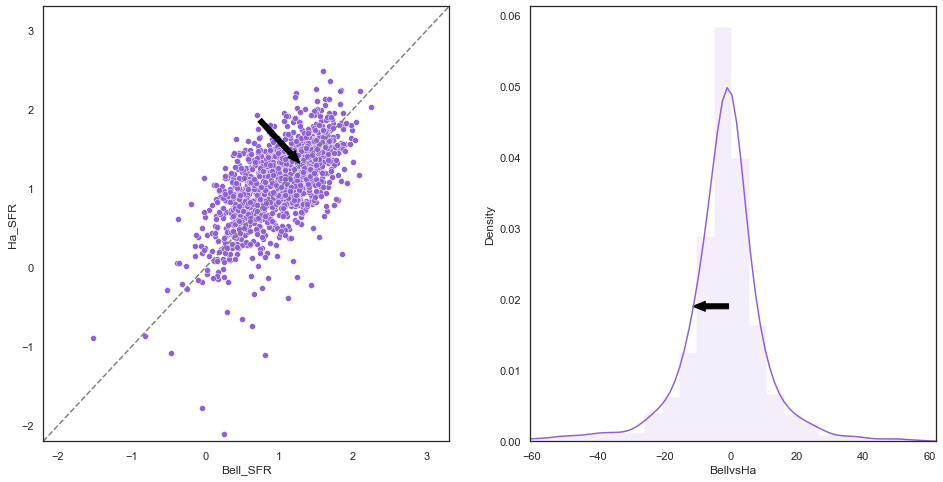

In [1492]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(16, 8))
sns.scatterplot(np.log10(SFR_all['Bell_SFR']), np.log10(SFR_all['Ha_SFR']), color="#8e61d4", ax=ax1)
ax1.set(xlim=(-2.2, 3.3), ylim=(-2.2,3.3))
ax1.plot(scatx, scatx, color='grey', alpha=1, linestyle='--')
arr = mpatches.FancyArrowPatch((0.717505,1.880142),(1.298,1.298), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
ax1.add_patch(arr)



sns.distplot(dist_df['BellvsHa'],
                 kde_kws={"color": "#8e61d4", "lw": 1.5},
                 hist_kws={"histtype": "stepfilled", "linewidth": 1, "alpha": 0.1, "color": "#8e61d4"},
                 norm_hist=True, ax=ax2)
ax2.set_xlim(dist_df[name].mean()-4*dist_df[name].std(), dist_df[name].mean()+4*dist_df[name].std() )
arr1 = mpatches.FancyArrowPatch((0,0.019),(-11.99,0.019), arrowstyle='simple,head_width=.4', mutation_scale=25, color='black')
ax2.add_patch(arr1)

### <span style='background :LightPink' > Mean distances to 1to1
   


In [1493]:
mean_dists=(['BellvsCondon',np.mean(dist_df['BellvsCondon'])],
        ['BellvsHa', np.mean(dist_df['BellvsHa'])],
        ['BellvsK09', np.mean(dist_df['BellvsK09'])],
        ['BellvsDust', np.mean(dist_df['BellvsDust'])],
        ['BellvsProspect_NoRadio', np.mean(dist_df['BellvsProspect_NoRadio'])],
        ['BellvsProspect_Radio', np.mean(dist_df['BellvsProspect_Radio'])],
            
        ['CondonvsHa', np.mean(dist_df['CondonvsHa'])],
        ['CondonvsK09',np.mean(dist_df['CondonvsK09'])],
        ['CondonvsDust', np.mean(dist_df['CondonvsDust'])],
        ['CondonvsProspect_NoRadio', np.mean(dist_df['CondonvsProspect_NoRadio'])],
        ['CondonvsProspect_Radio', np.mean(dist_df['CondonvsProspect_Radio'])],
            
        ['HavsK09', np.mean(dist_df['HavsK09'])],
        ['HavsDust', np.mean(dist_df['HavsDust'])],
        ['HavsProspect_NoRadio', np.mean(dist_df['HavsProspect_NoRadio'])],
        ['HavsProspect_Radio', np.mean(dist_df['HavsProspect_Radio'])],
            
        ['K09vsDust', np.mean(dist_df['K09vsDust'])],
        ['K09vsProspect_NoRadio', np.mean(dist_df['K09vsProspect_NoRadio'])],
        ['K09vsProspect_Radio', np.mean(dist_df['K09vsProspect_Radio'])],
            
        ['Prospect_NoRadiovsProspect_Radio', np.mean(dist_df['Prospect_NoRadiovsProspect_Radio'])]
           
           )

In [1106]:
mean_dists

(['BellvsCondon', -13.097953908334118],
 ['BellvsHa', -2.7029805084527716],
 ['BellvsK09', 2.6342227107215415],
 ['BellvsDust', 3.8916811085464826],
 ['BellvsProspect_NoRadio', 0.019855694031877816],
 ['BellvsProspect_Radio', 0.7843458220689159],
 ['CondonvsHa', 10.394973399881335],
 ['CondonvsK09', 15.732176619055648],
 ['CondonvsDust', 16.9896350168806],
 ['CondonvsProspect_NoRadio', 13.11780960236598],
 ['CondonvsProspect_Radio', 13.882299730403055],
 ['HavsK09', 5.337203219174308],
 ['HavsDust', 6.59466161699926],
 ['HavsProspect_NoRadio', 2.722836202484652],
 ['HavsProspect_Radio', 3.4873263305216815],
 ['K09vsDust', 1.25745839782495],
 ['K09vsProspect_NoRadio', -2.6143670166896644],
 ['K09vsProspect_Radio', -1.8498768886526278],
 ['Prospect_NoRadiovsProspect_Radio', 0.7644901280370385])

### <span style='background :LightPink' > Correlation Coefficient

In [1107]:
corrcoef=[]

corrcoef.append(['BellvsCondon',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Condon_SFR'])[0,1]])
corrcoef.append(['BellvsHa',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['BellvsK09',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['BellvsDust',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['BellvsProspect_NoRadio',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['BellvsProspect_Radio',np.corrcoef(SFR_all['Bell_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['CondonvsHa',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Ha_SFR'])[0,1]])
corrcoef.append(['CondonvsK09',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['CondonvsDust',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['CondonvsProspect_NoRadio',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['CondonvsProspect_Radio',np.corrcoef(SFR_all['Condon_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['HavsK09',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['K09_SFR'])[0,1]])
corrcoef.append(['HavsDust',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['HavsProspect_NoRadio',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['HavsProspect_Radio',np.corrcoef(SFR_all['Ha_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['K09vsDust',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Dust_SFR'])[0,1]])
corrcoef.append(['K09vsProspect_NoRadio',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Prospect_NoRadio_SFR'])[0,1]])
corrcoef.append(['K09vsProspect_Radio',np.corrcoef(SFR_all['K09_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])

corrcoef.append(['Prospect_NoRadiovsProspect_Radio',np.corrcoef(SFR_all['Prospect_NoRadio_SFR'],SFR_all['Prospect_Radio_SFR'])[0,1]])


In [1108]:
corrcoef

[['BellvsCondon', 0.9999781852298564],
 ['BellvsHa', 0.4829444010827501],
 ['BellvsK09', 0.4829444006745351],
 ['BellvsDust', 0.7544070010959012],
 ['BellvsProspect_NoRadio', 0.28707230984226706],
 ['BellvsProspect_Radio', 0.39917581953962006],
 ['CondonvsHa', 0.48358796706472745],
 ['CondonvsK09', 0.48358796666035],
 ['CondonvsDust', 0.7538929114812054],
 ['CondonvsProspect_NoRadio', 0.28724454749278866],
 ['CondonvsProspect_Radio', 0.39947024826487776],
 ['HavsK09', 0.9999999999999997],
 ['HavsDust', 0.5860932411469787],
 ['HavsProspect_NoRadio', 0.16330935421101622],
 ['HavsProspect_Radio', 0.22787487569297732],
 ['K09vsDust', 0.5860932398360732],
 ['K09vsProspect_NoRadio', 0.16330935370783697],
 ['K09vsProspect_Radio', 0.2278748755415749],
 ['Prospect_NoRadiovsProspect_Radio', 0.9169433718260463]]

## <span style='background :LightPink' > SUMMARY STATS FOR CORNER PLOT

In [1523]:
print("\033[1mBellvsCondon Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsCondon'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsCondon'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsCondon'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsCondon'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsCondon Values

 Distance to line of best fit:
 1       0.035646
2       0.271929
7       0.003331
11      0.023592
13      0.067009
          ...   
5701    0.062227
5707    0.268591
5716    0.080246
5722    0.082936
5724    0.062732
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1       -2.367773
2       -0.586750
7      -31.448957
11     -22.562677
13      -8.231905
          ...    
5701    -9.810369
5707    -0.504695
5716    -3.862848
5722   -57.724008
5724    -9.643636
Name: BellvsCondon, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: -13.097953908334118 

 The standard deviation of the distances to the 1-to-1 line is:  14.157636666843977 

 The correlation coefficient between them is: 0.4829444010827501


In [1524]:
print("\033[1mBellvsHa Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsHa'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsHa'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsHa'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsHa'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsHa Values

 Distance to line of best fit:
 1        6.926929
2        7.883160
7        4.193407
11       7.086399
13       5.631961
          ...    
5701     0.414252
5707     6.164384
5716     7.767005
5722    45.639548
5724     0.026210
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        0.117076
2        0.532157
7       -0.991419
11       6.027139
13       0.652117
          ...    
5701    -4.029820
5707    -0.953587
5716   -11.995703
5722    48.943615
5724    -3.703689
Name: BellvsHa, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: -2.7029805084527716 

 The standard deviation of the distances to the 1-to-1 line is:  15.290284003914179 

 The correlation coefficient between them is: 0.4829444010827501


In [1525]:
print("\033[1mBellvsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsK09 Values

 Distance to line of best fit:
 1        4.783386
2        5.443710
7        2.895753
11       4.893507
13       3.889146
          ...    
5701     0.286062
5707     4.256810
5716     5.363499
5722    31.516352
5724     0.018100
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        0.913814
2        0.721579
7        9.676512
11      11.133913
13       3.099945
          ...    
5701     0.704188
5707    -0.231174
5716    -6.197587
5722    49.338268
5724     0.852486
Name: BellvsK09, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 2.6342227107215415 

 The standard deviation of the distances to the 1-to-1 line is:  11.620959198525004 

 The correlation coefficient between them is: 0.4829444010827501


In [1526]:
print("\033[1mBellvsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsDust Values

 Distance to line of best fit:
 1        4.511425
2        5.402891
7       12.253018
11       2.677914
13       1.238545
          ...    
5701     4.298706
5707     4.047848
5716     5.635663
5722    31.487881
5724     5.361389
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        1.611837
2        0.888926
7       14.390027
11       9.146004
13       3.490349
          ...    
5701     2.987676
5707     0.454622
5716     2.731528
5722    49.878783
5724     0.967108
Name: BellvsDust, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 3.8916811085464826 

 The standard deviation of the distances to the 1-to-1 line is:  9.677517351070362 

 The correlation coefficient between them is: 0.4829444010827501


In [1530]:
print("\033[1mBellvsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsProspect_NoRadio Values

 Distance to line of best fit:
 1        -2.192642
2         2.566244
7      -762.427101
11       -4.747302
13        5.759384
           ...    
5701      2.095942
5707      2.936700
5716     -5.295813
5722     44.058154
5724     -4.874218
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -4.367220
2        -0.517090
7      -663.785860
11       -1.961687
13        3.915693
           ...    
5701      1.072381
5707     -0.212754
5716     -6.785836
5722     48.969409
5724     -5.073686
Name: BellvsProspect_NoRadio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 0.019855694031877816 

 The standard deviation of the distances to the 1-to-1 line is:  29.96203470261524 

 The correlation coefficient between them is: 0.4829444010827501


In [1531]:
print("\033[1mBellvsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['BellvsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['BellvsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['BellvsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['BellvsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

BellvsProspect_Radio Values

 Distance to line of best fit:
 1        -1.753024
2         2.818531
7      -298.880429
11       -2.443128
13        5.678258
           ...    
5701      1.458597
5707      3.300260
5716     -3.411943
5722     40.722415
5724     -6.404979
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -3.995432
2        -0.586026
7      -244.461997
11        1.655048
13        4.008217
           ...    
5701      0.957279
5707     -0.208753
5716     -4.985230
5722     48.852718
5724     -5.696860
Name: BellvsProspect_Radio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 0.7843458220689159 

 The standard deviation of the distances to the 1-to-1 line is:  18.464159988402702 

 The correlation coefficient between them is: 0.4829444010827501


In [1532]:
print("\033[1mCondonvsHa Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsHa'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsHa'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsHa'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsHa'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsHa Values

 Distance to line of best fit:
 1        7.917762
2        8.848307
7       -4.798637
11       8.162927
13       6.508764
          ...    
5701    -0.435382
5707     6.877025
5716    -8.871400
5722    52.391627
5724     0.070551
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1         2.484849
2         1.118907
7        30.457538
11       28.589815
13        8.884022
           ...    
5701      5.780548
5707     -0.448892
5716     -8.132856
5722    106.667623
5724      5.939947
Name: CondonvsHa, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 10.394973399881335 

 The standard deviation of the distances to the 1-to-1 line is:  23.427118299289575 

 The correlation coefficient between them is: 0.4829444010827501


In [1533]:
print("\033[1mCondonvsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsK09 Values

 Distance to line of best fit:
 1        5.062213
2        5.657156
7       -3.068003
11       5.218959
13       4.161372
          ...    
5701    -0.278362
5707     4.396819
5716    -5.671921
5722    33.496535
5724     0.045107
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1         3.281587
2         1.308329
7        41.125469
11       33.696590
13       11.331850
           ...    
5701     10.514556
5707      0.273521
5716     -2.334739
5722    107.062275
5724     10.496122
Name: CondonvsK09, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 15.732176619055648 

 The standard deviation of the distances to the 1-to-1 line is:  23.179566559763533 

 The correlation coefficient between them is: 0.4829444010827501


In [1534]:
print("\033[1mCondonvsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsDust Values

 Distance to line of best fit:
 1        4.956612
2        3.915998
7       19.078357
11      13.060841
13       7.000079
          ...    
5701     6.203577
5707     3.361866
5716     6.408039
5722    62.862722
5724     3.590537
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1         3.979611
2         1.475677
7        45.838984
11       31.708681
13       11.722254
           ...    
5701     12.798045
5707      0.959318
5716      6.594376
5722    107.602790
5724     10.610745
Name: CondonvsDust, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 16.9896350168806 

 The standard deviation of the distances to the 1-to-1 line is:  18.0873834883384 

 The correlation coefficient between them is: 0.4829444010827501


In [1535]:
print("\033[1mCondonvsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsProspect_NoRadio Values

 Distance to line of best fit:
 1        -2.605721
2         2.798056
7      -894.774220
11       -5.548781
13        6.807957
           ...    
5701      2.505680
5707      3.235329
5716     -6.158396
5722     51.664911
5724     -5.674160
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -1.999447
2         0.069661
7      -632.336903
11       20.600990
13       12.147598
           ...    
5701     10.882749
5707      0.291942
5716     -2.922988
5722    106.693417
5724      4.569950
Name: CondonvsProspect_NoRadio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 13.11780960236598 

 The standard deviation of the distances to the 1-to-1 line is:  34.503589222421574 

 The correlation coefficient between them is: 0.4829444010827501


In [1536]:
print("\033[1mCondonvsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['CondonvsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['CondonvsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['CondonvsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['CondonvsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

CondonvsProspect_Radio Values

 Distance to line of best fit:
 1        -2.025437
2         3.018055
7      -340.230676
11       -2.760186
13        6.506678
           ...    
5701      1.700731
5707      3.568655
5716     -3.834778
5722     46.325244
5724     -7.250721
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -1.627659
2         0.000724
7      -213.013040
11       24.217725
13       12.240123
           ...    
5701     10.767648
5707      0.295943
5716     -1.122382
5722    106.576725
5724      3.946776
Name: CondonvsProspect_Radio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 13.882299730403055 

 The standard deviation of the distances to the 1-to-1 line is:  25.79364523473256 

 The correlation coefficient between them is: 0.4829444010827501


In [1537]:
print("\033[1mHavsK09 Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsK09'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsK09'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsK09'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsK09'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsK09 Values

 Distance to line of best fit:
 1       5.104881e-08
2       2.685793e-08
7       4.567457e-08
11     -1.439360e-07
13      1.226792e-07
            ...     
5701   -2.661791e-07
5707    7.575157e-09
5716   -2.487384e-07
5722   -9.202634e-09
5724   -9.131286e-08
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        0.796738
2        0.189422
7       10.667931
11       5.106774
13       2.447827
          ...    
5701     4.734008
5707     0.722413
5716     5.798116
5722     0.394653
5724     4.556175
Name: HavsK09, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 5.337203219174308 

 The standard deviation of the distances to the 1-to-1 line is:  6.361803285233208 

 The correlation coefficient between them is: 0.4829444010827501


In [1538]:
print("\033[1mHavsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsDust Values

 Distance to line of best fit:
 1        1.476189
2        0.439767
7       13.494719
11       2.075403
13       2.461036
          ...    
5701     6.253021
5707     1.404552
5716    14.054152
5722     0.992977
5724     3.841176
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        1.494761
2        0.356769
7       15.381447
11       3.118866
13       2.838231
          ...    
5701     7.017496
5707     1.408210
5716    14.727231
5722     0.935168
5724     4.670797
Name: HavsDust, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 6.59466161699926 

 The standard deviation of the distances to the 1-to-1 line is:  14.449221431893315 

 The correlation coefficient between them is: 0.4829444010827501


In [1539]:
print("\033[1mHavsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsProspect_NoRadio Values

 Distance to line of best fit:
 1         1.600782
2         7.771000
7      -914.414699
11      -13.926616
13        7.960497
           ...    
5701      4.730562
5707      8.861299
5716      2.214254
5722      8.713128
5724     -3.587600
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -4.484296
2        -1.049246
7      -662.794441
11       -7.988825
13        3.263576
           ...    
5701      5.102201
5707      0.740834
5716      5.209867
5722      0.025794
5724     -1.369997
Name: HavsProspect_NoRadio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 2.722836202484652 

 The standard deviation of the distances to the 1-to-1 line is:  32.84931781199767 

 The correlation coefficient between them is: 0.4829444010827501


In [1540]:
print("\033[1mHavsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['HavsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['HavsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['HavsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['HavsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

HavsProspect_Radio Values

 Distance to line of best fit:
 1         1.684470
2         7.392975
7      -351.789367
11      -10.131768
13        7.504111
           ...    
5701      3.654358
5707      8.522544
5716      3.590788
5722      8.251613
5724     -5.415402
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -4.112508
2        -1.118183
7      -243.470578
11       -4.372090
13        3.356100
           ...    
5701      4.987100
5707      0.744835
5716      7.010474
5722     -0.090897
5724     -1.993171
Name: HavsProspect_Radio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 3.4873263305216815 

 The standard deviation of the distances to the 1-to-1 line is:  22.71342800926206 

 The correlation coefficient between them is: 0.4829444010827501


In [1541]:
print("\033[1mK09vsDust Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsDust'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsDust'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsDust'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsDust'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsDust Values

 Distance to line of best fit:
 1        1.126975
2        0.335734
7       10.302342
11       1.584435
13       1.878841
          ...    
5701     4.773776
5707     1.072285
5716    10.729434
5722     0.758074
5724     2.932489
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1       0.698023
2       0.167347
7       4.713515
11     -1.987909
13      0.390404
          ...   
5701    2.283488
5707    0.685797
5716    8.929115
5722    0.540515
5724    0.114623
Name: K09vsDust, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 1.25745839782495 

 The standard deviation of the distances to the 1-to-1 line is:  12.010152326030115 

 The correlation coefficient between them is: 0.4829444010827501


In [1542]:
print("\033[1mK09vsProspect_NoRadio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsProspect_NoRadio'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsProspect_NoRadio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsProspect_NoRadio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsProspect_NoRadio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsProspect_NoRadio Values

 Distance to line of best fit:
 1         1.504461
2         7.303411
7      -859.393456
11      -13.088638
13        7.481506
           ...    
5701      4.445919
5707      8.328106
5716      2.081020
5722      8.188850
5724     -3.371731
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -5.281034
2        -1.238669
7      -673.462372
11      -13.095600
13        0.815748
           ...    
5701      0.368193
5707      0.018421
5716     -0.588249
5722     -0.368859
5724     -5.926172
Name: K09vsProspect_NoRadio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: -2.6143670166896644 

 The standard deviation of the distances to the 1-to-1 line is:  31.14462527477798 

 The correlation coefficient between them is: 0.4829444010827501


In [1543]:
print("\033[1mK09vsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['K09vsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['K09vsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['K09vsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['K09vsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

K09vsProspect_Radio Values

 Distance to line of best fit:
 1         1.603293
2         7.036696
7      -334.836118
11       -9.643504
13        7.142477
           ...    
5701      3.478249
5707      8.111830
5716      3.417742
5722      7.853955
5724     -5.154426
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1        -4.909246
2        -1.307605
7      -254.138509
11       -9.478865
13        0.908273
           ...    
5701      0.253092
5707      0.022422
5716      1.212357
5722     -0.485550
5724     -6.549346
Name: K09vsProspect_Radio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: -1.8498768886526278 

 The standard deviation of the distances to the 1-to-1 line is:  19.97298495759083 

 The correlation coefficient between them is: 0.4829444010827501


In [1544]:
print("\033[1mProspect_NoRadiovsProspect_Radio Values\033[0m\n\n", 'Distance to line of best fit:\n',dist_LOBF['Prospect_NoRadiovsProspect_Radio'] , "\n\n Distance to the 1-to-1 line", dist_df['Prospect_NoRadiovsProspect_Radio'], '\n\n The mean distance to the 1-to-1 line is:', dist_df['Prospect_NoRadiovsProspect_Radio'].mean(), '\n\n The standard deviation of the distances to the 1-to-1 line is: ', dist_df['Prospect_NoRadiovsProspect_Radio'].std(),  '\n\n The correlation coefficient between them is:', corrcoef[1][1])

Prospect_NoRadiovsProspect_Radio Values

 Distance to line of best fit:
 1         2.010030
2         4.083412
7       160.477327
11       -1.741976
13        3.419491
           ...    
5701      0.982952
5707      4.369653
5716      1.926205
5722      4.300672
5724     -2.750157
Length: 1247, dtype: float64 

 Distance to the 1-to-1 line 1         0.371788
2        -0.068937
7       419.323863
11        3.616735
13        0.092525
           ...    
5701     -0.115101
5707      0.004001
5716      1.800606
5722     -0.116691
5724     -0.623174
Name: Prospect_NoRadiovsProspect_Radio, Length: 1247, dtype: float64 

 The mean distance to the 1-to-1 line is: 0.7644901280370385 

 The standard deviation of the distances to the 1-to-1 line is:  15.296438251094244 

 The correlation coefficient between them is: 0.4829444010827501
